<a href="https://colab.research.google.com/github/ImagingDataCommons/nnU-Net-BPR-annotations/blob/main/usage_notebooks/scientific_data_paper_usage_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Usage Notes Notebook for [insert name of paper]**

[insert reference for paper] 

---

## Overview

This notebook provides instructions on how to create, interpret and visualize the DICOM data associated with the Nature Scientific Data Paper [insert link and reference]. The paper details the efforts to enrich the annotations for the NSCLC-Radiomics dataset and a subset of the National Lung Screening Trial (NLST) collection. Specifically, we use two state of the art publicly available models, nnU-Net for thoracic organ segmentation and Body Part Regression for identifying landmarks and regions scanned. We then create DICOM Segmentation objects for the segmentations, structured reports (SRs) for radiomcis features extracted from the segmentations, and SRs for landmark and region scanned.  

Before beginning, please set up a project using [these instructions](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part1_prerequisites.ipynb). If you would like to learn more about NCI Imaging Data Commons before interacting with this data (e.g basics of BigQuery and understanding IDC tables) please refer to the other notebooks in [this repository](https://github.com/ImagingDataCommons/IDC-Tutorials/tree/master/notebooks/getting_started). 

For both use cases, we also include how we created the figures for the Nature Scientific Data. Many of these figures are interactive and open OHIF viewer links in the IDC portal. 

---

## Demonstrations

For nnU-Net prediction analysis, we demonstrate how to: 
- Download DICOM Segmentation objects and associated CT files from IDC public buckets 
- Convert DICOM CT files and DICOM Segmentation files using different software programs 
- Visualization of DICOM files and nifti files using ITKWidgets and custom code 
- Compare the expert segmentations to the AI-derived segmentations using the Dice score and Hausdorff distance
- Extracting and plotting distribution of radiomics features per segmentation region 
- Downloading and extracting fields from the DICOM radiomics SRs using various packages 

For Body Part Regression analysis, we demonstrate how to: 
- Query and extract values from the landmarks SRs and regions SRs
- Compare the differences between the lung landmarks to the expert lung segmentations 
- Visualize the distances between the lung landmarks across series
- Examples querying to see patients that have certain landmarks 
- Query for series that have specific regions 
- Visualize the distributions of ratios of regions
- How to download and extract relevant fields from the landmarks and regions SRs

---

References: 
1. [Nature Scientific Data paper] 
2. [nn-UNet paper]
3. [nn-UNet github page]
4. [Body Part Regression thesis]
5. [Body Part Regression github page] 

---

Deepa Krishnaswamy

Brigham and Women's Hospital 

March 2023

To do: 
- add input/output for all functions
- make code cleaner/shorter 
- reorder the cells according to what is interesting
- keep ordering same between cells 

In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Parameterization

In [ ]:
# Set to 1 if you want to calculate the Dice/HD metrics for every nnU-Net model 
# vs the expert. This process takes a long time, about 1 minute per series for a 
# total of 5 to 6 hours. If instead you want to load the metrics results, and 
# just plot, the results will be read from github. In this case, set to 0. 
run_figure_4_expert_vs_ai_segmentations = 0

# Set to 1 if you want to calculate the distance between the expert lungs vs the 
# lung_top and lung_bottom landmarks produced by BPR. This process could take a 
# long time as we have to download and convert the DICOM SEG objects to obtain 
# the lung segmentations. If instead you want to load the metrics results, and 
# just plot, the results will be read from github. In this case, set to 0. 
run_figure_8_expert_vs_ai_lung_segmentations = 0

# Install packages 

Let's first install some packages we need for conversion and visualization

In [ ]:
!pip install pyradiomics

!pip install pyplastimatch

!pip uninstall highdicom
!git clone https://github.com/herrmannlab/highdicom.git
#!cd highdicom && python setup.py install
!cd highdicom && pip install .

!pip install pydicom
!pip install pydicom-seg

!pip install --upgrade --pre -q "itk==5.3.0"
!pip install 'itkwidgets>=1.0a23'
!pip install imjoy-elfinder 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 KB 32.5 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp39-cp39-linux_x86_64.whl size=185752 sha256=6a6b670747605cd769b84031ddfd506adc900aae43d34ee195bb479f5ec7c700
  Stored in directory: /root/.cache/pip/wheels/62/0f/06/e8bdcc276fc814981e11a2fc4da7ad0da0a7e68a60fe90e747
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=ebbbcc09550a6be09ff1084371fd7ed5ad72037b7c282038a59518c8a10d7e98
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc85

Let's get some code that we need for metric computation and visualization

In [ ]:
%%capture
!apt install subversion

!svn checkout https://github.com/ImagingDataCommons/ai_medima_misc/trunk/nnunet/src
# !svn checkout https://github.com/ImagingDataCommons/ai_medima_misc/trunk/nnunet/data

Let's import the packages we need. 

In [ ]:
import os 
import sys 
import time 
import json 
import subprocess 
import glob
import shutil  

import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib 
import SimpleITK as sitk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
pd.options.mode.chained_assignment = None

import seaborn as sb 
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

import pydicom
import pydicom_seg
from collections import OrderedDict

import itk 
from itkwidgets import view
from scipy import ndimage

import seaborn as sns

# import src.utils.gcs as gcs
# import src.utils.preprocessing as preprocessing
# import src.utils.processing as processing
import src.utils.postprocessing as postprocessing # use code here to convert DICOM SEG to nii.gz 

from pathlib import Path  

Let's install packages for plotting, specifically bokeh

In [ ]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

Let's install and import the packages needed to create Structured Reports (SR).

In [ ]:
# Packages for the structured report 

import highdicom

from pathlib import Path

import highdicom as hd

from pydicom.uid import generate_uid
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

from highdicom.sr.content import (
    FindingSite,
    ImageRegion,
    ImageRegion3D,
    SourceImageForRegion,
    SourceImageForMeasurement,
    SourceImageForMeasurementGroup
)
from highdicom.sr.enum import GraphicTypeValues3D
from highdicom.sr.enum import GraphicTypeValues
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    MeasurementsAndQualitativeEvaluations,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation,
    ImageLibrary,
    ImageLibraryEntryDescriptors,
    ValueTypeValues # I added 
)
from highdicom.sr.value_types import (
    CodedConcept,
    CodeContentItem,
)

import logging
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes


We will next install and import a number of packages needed for organizing and converting DICOM files:

1.    `dicomsort`, a package for sorting DICOM files into a directory tree using specific DICOM fields. 
2.   `plastimatch`, a package used to convert RTSTRUCT DICOM files to nrrd. 
3.   `dcmqi`, a package which converts SEG DICOM files to nrrd.
4.  `dcm2niix`, a package for converting DICOM files to nii 


In [ ]:
# %%capture
start_time=time.time()

# FIXME: see if we can convert this to a package as well
# dicomsort 
if os.path.isdir('/content/src/dicomsort'):
  try:
    shutil.rmtree('/content/src/dicomsort')
  except OSError as err:
    print("Error: %s : %s" % ("dicomsort", err.strerror)) 
# !git clone https://github.com/pieper/dicomsort.git 
!git clone https://github.com/pieper/dicomsort.git src/dicomsort

# plastimatch and pyplastimatch
# FIXME: already installed in one of the first cells (also takes care of some
# of the other dependencies, e.g., SITK) 
!sudo apt install plastimatch 
import pyplastimatch as pypla

# FIXME: see if we can convert this to a package as well
# dcmqi 
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

# dcm2niix 
# !sudo apt-get install dcm2niix 
# !curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip "/content/dcm2niix_lnx.zip"
!wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
!unzip dcm2niix_lnx.zip
!cp /content/dcm2niix /usr/local/bin 

end_time = time.time()
print ('time to install: ' + str(end_time-start_time))

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 169 (delta 23), reused 34 (delta 17), pack-reused 126
Receiving objects: 100% (169/169), 87.85 KiB | 2.20 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdcmtk14 libdlib-data libdlib19 libfftw3-single3 libinsighttoolkit4.13
  libminc2-5.2.0 libnifti2
Suggested packages:
  libfftw3-bin libfftw3-dev
The following NEW packages will be installed:
  libdcmtk14 libdlib-data libdlib19 libfftw3-single3 libinsighttoolkit4.13
  libminc2-5.2.0 libnifti2 plastimatch
0 upgraded, 8 newly installed, 0 to remove and 24 not upgraded.
Need to get 80.1 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu

# Queries

In IDC version 13, the landmarks and regions results are not in a readable format in the qualitative_measurements table. Therefore, we use this query to get the landmarks and regions information. We have one query for NSCLC-Radiomics and the next for NLST. 

In [ ]:
landmarks_query_nsclc_radiomics = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_v13.dicom_all` bid -- Data source
  --bigquery-public-data.idc_v13.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_v13.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nsclc_radiomics"

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

In [ ]:
landmarks_query_nlst = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_v13.dicom_all` bid -- Data source
  --bigquery-public-data.idc_v13.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_v13.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nlst"

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""


# Functions

First we have some general functions for GCP. 

In [ ]:
def dataset_exists_in_project(project_id, dataset_id):
  """Check if a dataset exists in a project"""

  from google.cloud import bigquery
  from google.cloud.exceptions import NotFound

  client = bigquery.Client()
  dataset_id_full = '.'.join([project_id, dataset_id])

  try:
      client.get_dataset(dataset_id_full)  
      return True 
  except NotFound:
      return False 

In [ ]:
def create_dataset(project_name, dataset_id):

  """
  Create a dataset that will store the cohort_df table 

  Arguments:
    project_name : required - name of the GCP project.
    dataset_id   : required - name of the dataset to create
  
  Returns:
    dataset : returns the dataset created 
  """

  # Construct a BigQuery client object.
  client = bigquery.Client(project=project_name)

  # Construct a full Dataset object to send to the API.
  dataset_id_full = ".".join([project_name, dataset_id])
  dataset = bigquery.Dataset(dataset_id_full)

  # TODO(developer): Specify the geographic location where the dataset should reside.
  dataset.location = "US"

  # Send the dataset to the API for creation, with an explicit timeout.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.
  # dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
  dataset = client.create_dataset(dataset)  # Make an API request.

  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

  return dataset 


This function is for saving out the AI-derived vs expert segmentation results to a table.

In [ ]:
def append_row_to_bq_table_with_query_with_structure_name(project_name, 
                                                          dataset_name, 
                                                          table_name, 
                                                          value_SeriesInstanceUID, 
                                                          value_structure_name, 
                                                          value_model_name, 
                                                          row_to_insert): 

  table_id_fullname = '.'.join([project_name, dataset_name, table_name])
  # print('table_id_fullname: ' + str(table_id_fullname))

  query = f"""
    SELECT 
      COUNT(SeriesInstanceUID) AS num_instances
    FROM 
      {table_id_fullname}
    WHERE 
      SeriesInstanceUID IN UNNEST (@pat_id_change) AND 
      structure_name IN UNNEST (@structure_name) AND 
      model IN UNNEST (@model_name);
  """
  job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("pat_id_change", "STRING", [value_SeriesInstanceUID]), 
                                                         bigquery.ArrayQueryParameter("structure_name", "STRING", [value_structure_name]), 
                                                         bigquery.ArrayQueryParameter("model_name", "STRING", [value_model_name]), 
                                                         ]) 
  client = bigquery.Client(project=project_name)
  result = client.query(query, job_config=job_config)
  df_result = result.to_dataframe()
  count = df_result['num_instances'][0]
  print(count)
  
  if (count>=1):
    print("Cannot insert row because seriesInstanceUID and structure exist in table")
  else:
    print("Inserting row into table")
    client = bigquery.Client(project=project_name)
    dataset = client.dataset(dataset_name)
    table_ref = dataset.table(table_name)
    client.insert_rows_json(table = table_ref,
                            json_rows = row_to_insert,
                            skip_invalid_rows = False,
                            ignore_unknown_values = False)

  return 

This function is for saving out the lung expert segmentations compared to the body part predicted landmarks. 

In [ ]:
def append_row_to_bq_table_with_query_lung(project_name, 
                                           dataset_name, 
                                           table_name, 
                                           value_SeriesInstanceUID, 
                                           value_lung, 
                                           row_to_insert):
  
  table_id_fullname = '.'.join([project_name, dataset_name, table_name])
  # print('table_id_fullname: ' + str(table_id_fullname))

  query = f"""
    SELECT 
      COUNT(SeriesInstanceUID) AS num_instances
    FROM 
      {table_id_fullname}
    WHERE 
      SeriesInstanceUID IN UNNEST (@pat_id_change) AND 
      lung IN UNNEST (@value_lung);
  """
  job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("pat_id_change", "STRING", [value_SeriesInstanceUID]), 
                                                         bigquery.ArrayQueryParameter("value_lung", "STRING", [value_lung])
                                                         ]) 
  client = bigquery.Client(project=project_name)
  result = client.query(query, job_config=job_config)
  df_result = result.to_dataframe()
  count = df_result['num_instances'][0]
  print(count)
  
  if (count>=1):
    print("Cannot insert row because seriesInstanceUID and lung pos exist in table")
  else:
    print("Inserting row into table")
    client = bigquery.Client(project=project_name)
    dataset = client.dataset(dataset_name)
    table_ref = dataset.table(table_name)
    client.insert_rows_json(table = table_ref,
                            json_rows = row_to_insert,
                            skip_invalid_rows = False,
                            ignore_unknown_values = False)

  return 

This function is for finding the extent of the lung based on the nifti files of the left and/or right lung. 

In [ ]:
def find_lung_extents(seg_nifti_directory): 
  """ Finds the min and max values of the lung from a nifti directory of files converted from dcmqi
  """ 

  dicomseg_json = [os.path.join(seg_nifti_directory,f) for f in os.listdir(seg_nifti_directory) if f.endswith('.json')][0]

  # Get a mapping of the files from the json file to the label 
  label_values, label_names = get_label_and_names_from_metadata_json_all(dicomseg_json)

  # Get a list of just the ones that contain the lung
  label_names_lower = [f.lower() for f in label_names]

  to_include = np.asarray([f.find("lung") for f in label_names_lower]).astype(np.int32) # will be -1 for ones not found
  
  # if every value is -1, lung is not found 
  if (np.max(to_include)==-1):
    min_lung = -1 
    max_lung = -1
  else:
    # get values greater than -1 
    index_include = np.where(to_include>-1)[0]
    label_values_include = np.asarray(label_values)[index_include.astype(int)]
    label_names_include = np.asarray(label_names)[index_include.astype(int)]

    # If multiple, get min and max of each 
    num_labels_include = len(label_values_include)
    min_vals = [] 
    max_vals = [] 

    for n in range(0,num_labels_include):
      nii = nib.load(os.path.join(seg_nifti_directory,str(label_values_include[n])+'.nii.gz'))
      img = nii.get_fdata() 
      indices = np.where(img>0)[2] # z 
      min_val = min(indices)
      max_val = max(indices)
      min_vals.append(min_val)
      max_vals.append(max_val)

    # Get overall min and max 
    min_lung = np.min(np.asarray(min_vals))
    max_lung = np.max(np.asarray(max_vals))

  return min_lung, max_lung 

This parses a json file associated with the DICOM SEG file to get appropriate names for renaming NifTi files. 

In [ ]:
def get_label_and_names_from_metadata_json_all(dicomseg_json):

  """Returns two lists containing the label values and the corresponding
    CodeMeaning values. Takes into account the modifier
    "SegmentedPropertyTypeModifierCodeSequence for determining laterality. 

  Inputs: 
    dicomseg_json : metajson file

  Outputs:
    label_values  : label values from the metajson file 
    label_names   : the corresponding CodeMeaning values 
    """

  f = open(dicomseg_json)
  meta_json = json.load(f)

  # first_entry = meta_json['segmentAttributes']
  first_entry = meta_json['segmentAttributes'][0][0] 
  if (type(first_entry) is dict): 
    num_regions = len(meta_json['segmentAttributes'])
  else:
    num_regions = len(meta_json['segmentAttributes'][0])
  print('num_regions: ' + str(num_regions))

  label_values = [] 
  label_names = [] 

  for n in range(0,num_regions):
    if (type(first_entry) is dict):
      label_value = meta_json['segmentAttributes'][n][0]['labelID']
      label_name = meta_json['segmentAttributes'][n][0]['SegmentedPropertyTypeCodeSequence']['CodeMeaning']
      dict_key = "SegmentedPropertyTypeModifierCodeSequence"
      if (dict_key in meta_json['segmentAttributes'][n][0].keys()):
        label_modifier = meta_json['segmentAttributes'][n][0]['SegmentedPropertyTypeModifierCodeSequence']['CodeMeaning']
        label_name = label_name + '_' + label_modifier 
    else: 
      label_value = meta_json['segmentAttributes'][0][n]['labelID']
      label_name = meta_json['segmentAttributes'][0][n]['SegmentedPropertyTypeCodeSequence']['CodeMeaning']
    label_values.append(label_value)
    label_names.append(label_name)

  print('label_values: ' + str(label_values))
  print('label_names: ' + str(label_names))

  return label_values, label_names

In [ ]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    # print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    # print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

# nnU-Net prediction analysis

In this section, we focus on the analysis results created from the nnU-Net prediction analysis. This includes both the analysis and interaction with the DICOM Segmentation objects as well as the radiomics output. We demonstrate how to download files, convert the DICOM files to different formats, visualize and compare segmentation and radiomics results to the expert, etc. 

### Segmentation analysis

The first part of the analysis is to analyze and interact with the DICOM Segmentation objects. 

#### **(paper figure #4)** NSCLC Radiomics - comparison of expert segmentations and AI-derived segmentations

We first query to get a list of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection. We query for the ones that have a SegmentedPropertyType Code Meaning of Esophagus, Heart, Trachea or Aorta. The seg_SeriesInstanceUIDs will later be used to get a list of the corresponding AI-derived segmentations. 

In [ ]:
client = bigquery.Client(project=project_name)

query = """

# First get a list of the SOPInstanceUIDs of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection
WITH seg_sops AS (
  SELECT 
    PatientID, 
    SeriesInstanceUID, 
    SOPInstanceUID,
    SeriesDescription,
    gcs_url
  FROM 
    `bigquery-public-data.idc_v13.dicom_all`
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics" AND 
    Source_DOI = '10.7937/K9/TCIA.2015.PF0M9REI'
  ORDER BY 
    PatientID 
)

# Now join the above to get only the segmented_SeriesInstanceUIDs that have the regions we want
# We will use these to get the AI-derived DICOM Segmentation objects 
SELECT 
  DISTINCT(seg.segmented_SeriesInstanceUID), 
  seg.PatientID, 
  seg_sops.SOPInstanceUID,
  seg_sops.SeriesDescription,
  seg_sops.gcs_url

FROM 
  `bigquery-public-data.idc_v13.segmentations` as seg 
JOIN 
  seg_sops 
ON 
  seg.SOPInstanceUID = seg_sops.SOPInstanceUID
WHERE
  seg.SegmentedPropertyType.CodeMeaning = "Esophagus" OR 
  seg.SegmentedPropertyType.CodeMeaning = "Heart" OR
  seg.SegmentedPropertyType.CodeMeaning = "Trachea" OR
  seg.SegmentedPropertyType.CodeMeaning = "Aorta"
ORDER BY 
  seg.PatientID; 

"""

seg_expert_df = client.query(query).to_dataframe()


For each of the SeriesInstanceUIDs they reference, get a dataframe of the gcs_urls of the AI-derived segmentations 

In [ ]:
seg_expert_series_ids = list(set(seg_expert_df['segmented_SeriesInstanceUID'].values))

client = bigquery.Client(project=project_name)

query = """

# Now we need to get the gcs_urls etc for the AI-derived Segmentations, for the seriesInstanceUIDs from the expert 

# First we need to get the possible SOPInstanceUIDs for the seriesInstanceUIDs from the expert 
WITH seg_series AS (
  SELECT 
    PatientID, 
    segmented_SeriesInstanceUID, 
    SOPInstanceUID,
    SegmentedPropertyType.CodeMeaning as code_meaning
  FROM 
    `bigquery-public-data.idc_v13.segmentations` 
  WHERE
    segmented_SeriesInstanceUID IN UNNEST(@series_ids) 
)  

# Now need to get the SeriesDescription and gcs_url for those DICOM Segmentation objects 
SELECT 
  DISTINCT(seg_series.segmented_SeriesInstanceUID),
  dicom_all.PatientID, 
  dicom_all.SOPInstanceUID,
  dicom_all.SeriesDescription,
  dicom_all.gcs_url
FROM 
  `bigquery-public-data.idc_v13.dicom_all` as dicom_all
JOIN 
  seg_series 
ON 
  seg_series.SOPInstanceUID = dicom_all.SOPInstanceUID 
WHERE
  dicom_all.Modality = "SEG" AND 
  dicom_all.source_DOI = '10.5281/zenodo.7539035' 
ORDER BY 
  dicom_all.PatientID
"""

job_config = bigquery.QueryJobConfig(    
    query_parameters=[
        bigquery.ArrayQueryParameter("series_ids", "STRING", seg_expert_series_ids)])
seg_ai_df = client.query(query, job_config=job_config).to_dataframe()

The above seg_ai_df only has the patients that were processed. Therefore, we modify our seg_expert_df to include those patients. 

In [ ]:
seg_ai_series = list(set(seg_ai_df['segmented_SeriesInstanceUID'].values))
seg_expert_df = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID'].isin(seg_ai_series)]
print(len(seg_expert_df))

349


For each series, and for each nnU-Net model (3 per series), we want to compare the AI-derived model to the expert segmentation. This involves downloading the expert DICOM Segmentation object for the expert and AI-derived model, converting to NifTi, computing the Dice score and Hausdorff distance, and saving the results to a BigQuery table. This process takes a while, about 1 minute per series. Therefore, it'll take about 5-6 hours. To make it easier, we've done this and stored the metrics in a csv in github. This way, you can load the results and still create the plots yourself. 

If we are not calculating the Dice/HD metrics from scratch, execute the following cell to load the results from github. 

In [ ]:
# --- Load the table from github ---# 
if not run_figure_4_expert_vs_ai_segmentations:

  # Get the csv 
  segmentation_metrics_expert_vs_ai_csv = "/content/segmentation_metrics_expert_vs_ai.csv"
  !wget -O $segmentation_metrics_expert_vs_ai_csv https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/segmentation_metrics_expert_vs_ai.csv
  # Convert to dataframe 
  seg_expert_vs_ai_df = pd.read_csv(segmentation_metrics_expert_vs_ai_csv) 
  

--2023-04-05 16:24:31--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/segmentation_metrics_expert_vs_ai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 453417 (443K) [text/plain]
Saving to: ‘/content/segmentation_metrics_expert_vs_ai.csv’

/content/segmentati 100%[===================>] 442.79K  --.-KB/s    in 0.01s   

2023-04-05 16:24:31 (32.0 MB/s) - ‘/content/segmentation_metrics_expert_vs_ai.csv’ saved [453417/453417]



If we are calculating the Dice/HD metrics from scratch, execute the following cell. 

In [ ]:
# --- Calculate the metrics for each series --- # 
# --- Takes 1 minute per series, 5-6 hours --- # 
# --- Save to a bigQuery table --- # 
if (run_figure_4_expert_vs_ai_segmentations):

  # --- Create the dataset, which will hold the bigquery tables to store the results --- # 

  dataset_table_id = 'dataset_nsclc' 
  nnunet_comparison_table_id = 'usage_notebook_nnunet_comparison_table'

  # Check if the dataset exists within the project 
  dataset_exists = dataset_exists_in_project(project_name, dataset_table_id)
  # If it does not exist, create the dataset 
  if not dataset_exists: 
    print ('creating dataset: ' + str(dataset_table_id))
    create_dataset(project_name, dataset_table_id)
  else:
    print ('dataset ' + str(dataset_table_id) + ' already exists.')

  # --- Create the bigquery tables to store the results --- # 
  # Set up the run parameters 
  # Dice score and HD score table 
  # If table doesn't exist, create the schema based on the above 

  from google.cloud.exceptions import NotFound
  client = bigquery.Client(project=project_name)

  nnunet_comparison_table_id_fullname = '.'.join([project_name, dataset_table_id, nnunet_comparison_table_id])
  print('nnunet_comparison_table_id_fullname: ' + str(nnunet_comparison_table_id_fullname))

  try:
    client.get_table(nnunet_comparison_table_id_fullname) 
    nnunet_comparison_table_exists = 1 
  except NotFound: 
    nnunet_comparison_table_exists = 0 

  if (nnunet_comparison_table_exists==0):

    schema = [
        bigquery.SchemaField("PatientID", "STRING", mode="REQUIRED"), 
        bigquery.SchemaField("SeriesInstanceUID", "STRING", mode="REQUIRED"), 
        bigquery.SchemaField("structure_name", "STRING", mode="REQUIRED"), # added
        bigquery.SchemaField("dice_score", "FLOAT", mode="REQUIRED"), # added instead of time 
        bigquery.SchemaField("hausdorff_distance", "FLOAT", mode="REQUIRED"), # added instead of time 
        bigquery.SchemaField("hausdorff_distance_95", "FLOAT", mode="REQUIRED"), # added instead of time 
        bigquery.SchemaField("model", "STRING", mode="REQUIRED"), 
    ] 

    table = bigquery.Table(nnunet_comparison_table_id_fullname, schema=schema)
    table = client.create_table(table)  # Make an API request.
    print(
        "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
    )

  else: 
    print ("Table " + str(nnunet_comparison_table_id_fullname) + ' already exists.')

  
  # --- get the series to eval --- # 

  series_to_eval_id_list = list(set(seg_expert_df['segmented_SeriesInstanceUID'].values))

  ai_derived_comparison_df = pd.DataFrame() 
  ai_derived_series_descriptions = list(set(seg_ai_df['SeriesDescription'].values))

  print(ai_derived_series_descriptions)

  segmented_SeriesInstanceUIDs = [] 
  structure_names = [] 
  seriesDescriptions = [] 
  dice_scores = [] 
  hausdorff_distances = [] 
  hausdorff_distances_95 = [] 

  eval_dice = True 
  eval_hausdorff = True

  # --- for each series --- #

  for idx, series_id in enumerate(series_to_eval_id_list):

    print("(%g/%g) Running evaluation for series %s"%(idx + 1, len(series_to_eval_id_list), series_id))

    # Get the df of the expert 
    seg_expert_df_series = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]

    patient_id = seg_expert_df_series["PatientID"].values[0] 
    print('PatientID: ' + str(patient_id))

    # Download expert 
    # Create the text file to hold gsc_url 
    gcsurl_temp = seg_expert_df_series["gcs_url"]
    gs_file_path = "gcs_paths.txt"
    gcsurl_temp.to_csv(gs_file_path, header = False, index = False)
    # Download the series 
    seg_expert_directory = "/content/seg_expert"
    if not os.path.isdir(seg_expert_directory):
      os.mkdir(seg_expert_directory)
    # !cat manifest.txt | gsutil -m cp -I .
    !cat gcs_paths.txt | gsutil -m cp -I $seg_expert_directory

    # Rename this file 
    input_path = os.path.join(seg_expert_directory, os.listdir(seg_expert_directory)[0])
    output_path = os.path.join(seg_expert_directory, series_id + '.dcm')
    shutil.move(input_path,output_path)

    # Create the appropriate folders 
    manual_dicomseg_path = output_path
    manual_seg_folder_path = "/content/seg_expert_nrrd"
    if not os.path.isdir(manual_seg_folder_path): 
      os.mkdir(manual_seg_folder_path)

    # convert the DICOM SEG obbject storing the inference results into NRRD
    postprocessing.dicomseg_to_nrrd(path_to_dicomseg_file = manual_dicomseg_path,
                                    path_to_output_dir = manual_seg_folder_path)

    # Get the df of the ai-derived 
    seg_ai_df_series = seg_ai_df[seg_ai_df['segmented_SeriesInstanceUID']==series_id]

    # --- for each model ---# 
    for nnunet_model in ai_derived_series_descriptions: 

      print ('nnunet_model: ' + str(nnunet_model))

      # Get the gcs_url of the specific model 
      seg_ai_df_series_model = seg_ai_df_series[seg_ai_df_series['SeriesDescription']==nnunet_model]

      # Download ai derived 
      # Create the text file to hold gsc_url 
      gcsurl_temp = seg_ai_df_series_model["gcs_url"]
      gs_file_path = "gcs_paths.txt"
      gcsurl_temp.to_csv(gs_file_path, header = False, index = False)
      # Download the series 
      seg_ai_directory = "/content/seg_ai"
      if not os.path.isdir(seg_ai_directory):
        os.mkdir(seg_ai_directory)
      # !cat manifest.txt | gsutil -m cp -I .
      !cat gcs_paths.txt | gsutil -m cp -I $seg_ai_directory

      # Rename this file 
      input_path = os.path.join(seg_ai_directory, os.listdir(seg_ai_directory)[0])
      output_path = os.path.join(seg_ai_directory, series_id + '.dcm')
      shutil.move(input_path,output_path)

      # Create the appropriate folders 
      pred_dicomseg_path = output_path
      pred_seg_folder_path = "/content/seg_ai_nrrd"
      if not os.path.isdir(pred_seg_folder_path): 
        os.mkdir(pred_seg_folder_path)

      # Create dicts 
      dc_dict = dict()
      hd_dict = dict()
      
      dc_dict[series_id] = dict()
      hd_dict[series_id] = dict()

      # clear_output(wait = True)

      # convert the DICOM SEG obbject storing the inference results into NRRD
      postprocessing.dicomseg_to_nrrd(path_to_dicomseg_file = pred_dicomseg_path,
                                      path_to_output_dir = pred_seg_folder_path)

      # the evaluation must be run on the structures that have a manual ground truth only
      pred_structure_list = [f for f in os.listdir(pred_seg_folder_path) if ".nrrd" in f]
      manual_structure_list = [f for f in os.listdir(manual_seg_folder_path) if ".nrrd" in f]
      eval_structure_list = list(set(pred_structure_list).intersection(set(manual_structure_list)))

      # --- for each structure --- # 
      for structure_fn in eval_structure_list:

        pred_seg_nrrd_path = os.path.join(pred_seg_folder_path, structure_fn)
        manual_seg_nrrd_path = os.path.join(manual_seg_folder_path, structure_fn)
        print('pred_seg_nrrd_path: ' + str(pred_seg_nrrd_path))
        print('manual_seg_nrrd_path: ' + str(manual_seg_nrrd_path))

        structure_name = os.path.splitext(structure_fn)[0]
        print('structure_name: ' + str(structure_name))

        # Dice Coefficient
        if eval_dice == True:
          try: 
              dc_summary_dict = pypla.dice(path_to_reference_img = manual_seg_nrrd_path,
                                          path_to_test_img = pred_seg_nrrd_path)

              dc_dict[series_id][structure_name] = dc_summary_dict

          except Exception as e:
              dc_dict[series_id][structure_name] = dict()
              print(e)

        # Hausdorff Coefficient
        if eval_hausdorff == True:
          try: 
              # hd_summary_dict = pypla.hd(path_to_reference_img = manual_seg_nrrd_path,
              #                            path_to_test_img = pred_seg_nrrd_path)

              # hd_dict[series_id][structure_name] = hd_summary_dict
              bash_command = list()
              bash_command += ["plastimatch", "dice", "--hausdorff"]
              bash_command += [manual_seg_nrrd_path, pred_seg_nrrd_path]
              hausdorff_summary = subprocess.run(bash_command, capture_output = True, check = True)
              hd_dict[series_id][structure_name]= {}
              metric_names = [f.split("=")[0] for f in str(hausdorff_summary.stdout).split("\\n")]
              print("metric_names: " + str(metric_names))
              # ind = metric_names.index("Hausdorff distance ")
              # find first instance where one of the metrics contains "Hausdorff distance "
              ind = np.where(np.asarray([f.find("Hausdorff distance") for f in metric_names]) != -1)[0][0]
              hd_dict[series_id][structure_name]["hd"] = float(str(hausdorff_summary.stdout).split("\\n")[ind].split("=")[1])
              hd_dict[series_id][structure_name]["hd95"] = float(str(hausdorff_summary.stdout).split("\\n")[ind+3].split("=")[1]) 

          except Exception as e:
              hd_dict[series_id][structure_name] = dict()
              print(e)

        # Add to overall dataframe 
        # ai_derived_comparison_table
        segmented_SeriesInstanceUIDs.append(series_id)
        structure_names.append(structure_name)
        seriesDescriptions.append(nnunet_model)
        dice_scores.append(np.float64(dc_dict[series_id][structure_name]['dc']))
        hausdorff_distances.append(np.float64(hd_dict[series_id][structure_name]['hd'])) 
        hausdorff_distances_95.append(np.float64(hd_dict[series_id][structure_name]['hd95']))

        # add to table 
        row_to_insert = [] 
        row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                          ("SeriesInstanceUID", series_id), 
                                          ("structure_name", str(structure_name)), 
                                          ("dice_score", np.float64(dc_dict[series_id][structure_name]['dc'])), 
                                          ("hausdorff_distance", np.float64(hd_dict[series_id][structure_name]['hd'])),
                                          ("hausdorff_distance_95", np.float64(hd_dict[series_id][structure_name]['hd95'])), 
                                          ("model", nnunet_model)
                                          ])
        row_to_insert.append(row_to_insert_dict)

        append_row_to_bq_table_with_query_with_structure_name(project_name, 
                                                              dataset_table_id, 
                                                              nnunet_comparison_table_id, 
                                                              series_id, 
                                                              structure_name, 
                                                              nnunet_model, 
                                                              row_to_insert)

      # --- For each model --- #
      !rm -r /content/seg_ai 
      !rm -r /content/seg_ai_nrrd
    
    # --- For each series --- # 
    !rm -r /content/seg_expert 
    !rm -r /content/seg_expert_nrrd

  # # Form the df 
  # ai_derived_comparison_df['segmented_SeriesInstanceUID'] = segmented_SeriesInstanceUIDs
  # ai_derived_comparison_df['structure_name'] = structure_names 
  # ai_derived_comparison_df['seriesDescription'] = seriesDescriptions
  # ai_derived_comparison_df['dice_score'] = dice_scores
  # ai_derived_comparison_df['hausdorff_distance'] = hausdorff_distances 
  # ai_derived_comparison_df['hausdorff_distance_95'] = hausdorff_distances_95

  # --- Load the table from bigQuery --- # 

  client = bigquery.Client(project=project_name)
  nnunet_comparison_table_id_fullname = ".".join([project_name, dataset_table_id, nnunet_comparison_table_id])
  print('nnunet_comparison_table_id_fullname: ' + str(nnunet_comparison_table_id_fullname)) 
  query = f"""
    SELECT 
      * 
    FROM 
      {nnunet_comparison_table_id_fullname};
  """
  seg_expert_vs_ai_df = client.query(query).to_dataframe()


Create plots for each of the metrics comparing the AI-derived segmentations to the ground truth for each region 

In [ ]:
def create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance): 
  """ This function creates a bokeh plot for the particular structure and 
      distance metric

      Inputs: 
        seg_expert_vs_ai_df   : a dataframe containing columns holding at minimum the: 
                                    SeriesInstanceUID
                                    structure_name
                                    dice_score
                                    hausdorff_distance
                                    hausdorff_distance_95 
                                    model 
                                    viewer_url 
        structure_name        : name of the anatomical structure to plot 
                                    e.g. Aorta, Trachea, Esophagus, Heart 
        column_name_distance  : name of the distance metric to plot 
                                    e.g. dice_score, hausdorff_distance, 
                                         hausdorff_distance_95 

      Outputs: 
        creates a bokeh plot in the notebook 
  """ 

  # output_notebook()
  output_file('bokeh_plot.html')

  # Get the structure to plot
  df_plot_structure = seg_expert_vs_ai_df[seg_expert_vs_ai_df["structure_name"]==structure_name]

  # Create table where name of column is called 'distance'
  df_plot = df_plot_structure.rename({column_name_distance: 'distance'}, axis=1)

  # Get a color for each region 
  colormap, colors = color_list_generator(df_plot, 'model')
  df_plot['colors'] = colors
  colormap_list_keys = list(colormap.keys())

  regions = colormap_list_keys 
  colors = list(colormap.values())

  hover = HoverTool(tooltips=[
      ("(Distance)", "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  cats = regions

  cats2 = [] 
  for c in range(0,len(cats)): 
    cats2.append(cats[c])
    cats2.append(cats[c]+"_boxplot")
  regions = cats2

  colors2 = [] 
  for c in range(0,len(colors)):
    colors2.append(colors[c])
    colors2.append(colors[c])

  p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
            x_range=regions,
            title="Distance metric")

  l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')

  legend = Legend(items=[LegendItem(label=dict(field="model"), renderers=[l1])])
  
  p1.add_layout(legend, 'below')    

  ### Include the box plots ### 
  # find the quartiles and IQR for each category

  df_plot2 = df_plot.copy(deep=True)
  df_plot2['model2'] = [f + '_boxplot' for f in df_plot['model'].values]

  # regions are in order we want 
  category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
  df_plot2['model2'] = df_plot2['model2'].astype(category_experiment)

  # groups = df_plot.groupby('experiment')
  groups = df_plot2.groupby('model2')
  q1 = groups.quantile(q=0.25)
  q2 = groups.quantile(q=0.5)
  q3 = groups.quantile(q=0.75)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr
  
  # Form the source data to call vbar for upper and lower
  # boxes to be formed later.
  upper_source = ColumnDataSource(data=dict(
      x=cats2, 
      bottom=q2.distance,
      top=q3.distance,
      fill_color=colors2,
      legend=cats2
  ))
  
  lower_source = ColumnDataSource(data=dict(
      x=cats2, 
      bottom=q1.distance,
      top=q2.distance,
      fill_color=colors2
  ))
  
  # stems (Don't need colors of treatment)
  p1.segment(cats2, upper.distance, cats2, q3.distance, line_color="black")
  p1.segment(cats2, lower.distance, cats2, q1.distance, line_color="black")
  
  # Add the upper and lower quartiles
  l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  
  # whiskers (almost-0 height rects simpler than segments)
  p1.rect(cats2, lower.distance, 0.2, 0.000001, line_color="black") # was 0.01
  p1.rect(cats2, upper.distance, 0.2, 0.000001, line_color="black")

  # Using the newer autogrouped syntax.
  # Grab a renderer, in this case upper quartile and then
  # create the legend explicitly.  
  # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
  # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
    
  # Setup plot titles and such.
  p1.title.text = str(column_name_distance) + '_' + str(structure_name)
  p1.xgrid.grid_line_color = None
  p1.ygrid.grid_line_color = "white"
  p1.grid.grid_line_width = 2
  p1.xaxis.major_label_text_font_size="0pt"
  p1.xaxis.major_label_orientation = np.pi/4
  p1.xaxis.axis_label = 'Models'
  p1.yaxis.axis_label = column_name_distance
  p1.legend.location = (100,10)

  p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
  p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

  url="@viewer_url"
  taptool = p1.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  show(p1)

  return 


In [ ]:
# structure_list = list(set(seg_expert_vs_ai_df['structure_name'].values))
# num_structures = len(structure_list)
# column_names_distance = ['dice_score', 'hausdorff_distance', 'hausdorff_distance_95']

Run each cell below to create a bokeh plot for each region (Heart, Esophagus) and distance metric (dice_score, hausdorff_distance, hausdorff_distance_95)

In [ ]:
structure_name = "Heart"
column_name_distance = "dice_score"
create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance)

In [ ]:
structure_name = "Heart"
column_name_distance = "hausdorff_distance"
create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance)

In [ ]:
structure_name = "Heart"
column_name_distance = "hausdorff_distance_95"
create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance)

In [ ]:
structure_name = "Esophagus"
column_name_distance = "dice_score"
create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance)

In [ ]:
structure_name = "Esophagus"
column_name_distance = "hausdorff_distance"
create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance)

In [ ]:
structure_name = "Esophagus"
column_name_distance = "hausdorff_distance_95"
create_bokeh_plot_paper_figure_4(seg_expert_vs_ai_df, structure_name, column_name_distance)

#### Download

Now we will demonstrate how to download from IDC the DICOM Segmentation objects and associated DICOM CT files from the NSCLC-Radiomics collection.

##### Download DICOM Segmentation objects 

Get the gcs url to download the SEG files 

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    SeriesDescription,
    gcs_url
  FROM 
    {table_id}
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID, 
    StudyInstanceUID, 
    SeriesInstanceUID;
"""

seg_df = client.query(query).to_dataframe()

bigquery-public-data.idc_v13.dicom_all


Choose single patient and download the files 

In [ ]:
PatientID = sorted(list(set(seg_df['PatientID'].values)))[1] 
print(PatientID)

LUNG1-002


In [ ]:
seg_df_patient = seg_df[seg_df['PatientID']==PatientID] 
seg_df_patient

PatientID                                   StudyInstanceUID  \
4  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
5  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
6  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
7  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   

                                   SeriesInstanceUID  \
4  1.2.276.0.7230010.3.1.3.2323910823.11504.15972...   
5  1.2.276.0.7230010.3.1.3.481034752.112041.16656...   
6  1.2.276.0.7230010.3.1.3.481034752.398262.16657...   
7  1.2.276.0.7230010.3.1.3.481034752.68078.166429...   

                                      SOPInstanceUID  \
4  1.2.276.0.7230010.3.1.4.2323910823.11504.15972...   
5  1.2.276.0.7230010.3.1.4.481034752.112041.16656...   
6  1.2.276.0.7230010.3.1.4.481034752.398262.16657...   
7  1.2.276.0.7230010.3.1.4.481034752.68078.166429...   

                     SeriesDescription  \
4                         Segmentation   
5   3d_lowres-tta_nnU-Net_Segmentation   
6          2d-tta_nnU-Net_Segmentation   
7  3d_fullres-tta_nnU-Net_Segmentation   

                                             gcs_url  
4  gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...  
5  gs://public-datasets-idc/99ce9653-4f74-4954-aa...  
6  gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9e...  
7  gs://public-datasets-idc/a8adc5d1-d4af-4653-96...

Download the SEG files 

In [ ]:
# Download all the DICOM Segmentation files 

# Create the text file to hold gsc_url 
gcsurl_temp = seg_df_patient["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
seg_directory = "/content/seg"
if not os.path.isdir(seg_directory):
  os.mkdir(seg_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $seg_directory

Copying gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bceaac5da9.dcm...
Copying gs://public-datasets-idc/99ce9653-4f74-4954-aa00-e94470abeee7.dcm...
Copying gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9ee9-e98d47b212d5.dcm...
Copying gs://public-datasets-idc/a8adc5d1-d4af-4653-966a-f0132333fd7e.dcm...
| [4/4 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 4 objects/41.8 MiB.                                     


Use dicomsort to sort the DICOM files 

In [ ]:
# Sort files 
seg_directory_sorted = "/content/seg_sorted"
if not os.path.join(seg_directory_sorted):
  os.mkdir(seg_directory_sorted)

!python src/dicomsort/dicomsort.py -u $seg_directory $seg_directory_sorted/%PatientID/%Modality/%SeriesDescription.dcm



100% 4/4 [00:00<00:00,  4.15it/s]
Files sorted


In [ ]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

##### Download the associated DICOM CT files 

In [ ]:
# Get the referenced seriesInstanceUID from the input_dicom 

dcm = pydicom.dcmread(input_dicom)
series_id = dcm.ReferencedSeriesSequence[0]['SeriesInstanceUID'].value 
series_id

'1.3.6.1.4.1.32722.99.99.232988001551799080335895423941323261228'

In [ ]:
client = bigquery.Client(project=project_name)
  
query_view = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url 
  FROM
    `bigquery-public-data.idc_v13.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

start_time = time.time()
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
result = client.query(query_view, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
end_time = time.time()
print ('elapsed time: ' + str(end_time-start_time)) 

elapsed time: 3.647213935852051


In [ ]:
# Download the gcs_urls 

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path = "/content/raw"
if not os.path.isdir(download_path):
  os.mkdir(download_path)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path

Copying gs://idc-open-cr/8d11ef77-909c-4de3-b550-cb3bd7f00d8a.dcm...
Copying gs://idc-open-cr/07610515-ec98-4852-bdd8-0dd5a91f5478.dcm...
Copying gs://idc-open-cr/66065989-9029-40c3-9f3f-66794ecaca3b.dcm...
Copying gs://idc-open-cr/52ea13a8-f89b-4da0-8435-0293d117069a.dcm...
Copying gs://idc-open-cr/b670ab0d-71a0-4a30-af78-c0676666d81d.dcm...
Copying gs://idc-open-cr/8ddfd645-fa50-4843-bce7-a629988a0c38.dcm...
Copying gs://idc-open-cr/ebed7073-8a61-46f8-adf0-929a39e1e8b8.dcm...
Copying gs://idc-open-cr/93361b61-85b9-4fc0-b015-d02245f2459c.dcm...
Copying gs://idc-open-cr/b85dc3e1-8c86-473d-a62d-0bb0f4b10a89.dcm...
Copying gs://idc-open-cr/e19d7bac-6a3c-49b5-98af-85e0f2f29491.dcm...
Copying gs://idc-open-cr/1376a75c-256a-4f27-83b9-a71a4128500d.dcm...
Copying gs://idc-open-cr/eafbfe99-84f0-44e5-a31d-21856912dc4d.dcm...
Copying gs://idc-open-cr/29946a45-da88-447c-9738-56c75a3824e1.dcm...
Copying gs://idc-open-cr/a5eafb01-8504-482f-930c-86720d3dbf0f.dcm...
Copying gs://idc-open-cr/7c0c66cb-

#### Conversion of DICOM files

Now that we have downloaded both the CT files and the DICOM SEG files, we demonstrate how to convert these to the NifTi (nii) format. 

##### Convert the DICOM CT files to nii 

In [ ]:
# Convert to nifti 
ct_nifti_directory = "/content/ct_nii" 
if not os.path.isdir(ct_nifti_directory): 
  os.mkdir(ct_nifti_directory)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory, download_path)
print(cmd)
ret = os.system(cmd)
print(ret)

dcm2niix -z y -m y -o /content/ct_nii  /content/raw 
0


In [ ]:
# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory,f) for f in os.listdir(ct_nifti_directory) if f.endswith('.nii.gz')][0] 
nii_file = "/content/ct.nii.gz"
os.rename(nii_file_orig, nii_file)


##### DICOM SEG files to nii

There are multiple packages to convert DICOM SEG to nifti. We focus on using dcmqi, pydicom_seg and highdicom. 

###### dcmqi

The function `segimage2itkimage` converts a DICOM SEG file to nrrd, nii.gz, etc. Here we convert to nii.gz. It creates a separate file numbered numerically for each segment in the DICOM SEG file. 

In [ ]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

In [ ]:
output_directory_seg_converted_dcmqi = "/content/seg_converted_dcmqi"
if not os.path.isdir(output_directory_seg_converted_dcmqi):
  os.mkdir(output_directory_seg_converted_dcmqi)

print(input_dicom)
print(output_directory_seg_converted_dcmqi)

!segimage2itkimage --outputType "nii" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 


/content/seg_sorted/LUNG1-002/SEG/2d-tta_nnU-Net_Segmentation.dcm
/content/seg_converted_dcmqi
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 1 0 0
Col direction: 0 -1 0
Z direction: 0 0 -1
Total frames: 205
Total frames with unique IPP: 85
Total overlapping frames: 77
Origin: [-250.112, 249.135, 154.6]


The DICOM SEG files were originally created using `dcmqi` `itkimage2segimage `with the flag `--skip`, which skips the saving of slices that do not have segmentations. This saves space in the DICOM SEG file. Later we'll want to overlay the segmentation nifti files on the original CT data. To make this process easier, we will resample these segmentations back to the original size of the CT volume. For this we will use the `plastimatch` package. 

In [ ]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_dcmqi,f) for f in os.listdir(output_directory_seg_converted_dcmqi) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_dcmqi_resampled = "/content/seg_converted_dcmqi_resampled"
if not os.path.isdir(output_directory_seg_converted_dcmqi_resampled):
  os.mkdir(output_directory_seg_converted_dcmqi_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_dcmqi, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_dcmqi_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

num_seg_files: 4
Trying to write image to /content/seg_converted_dcmqi_resampled/1.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/2.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/3.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/4.nii.gz


Let's now combine these resampled nii.gz files into a single label file and save it out. 

In [ ]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_dcmqi_resampled,f) for f in os.listdir(output_directory_seg_converted_dcmqi_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
    
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/seg_dcmqi_resampled.nii.gz')


[0. 1. 2. 3. 4.]


###### pydicom_seg

Another option of conversion from DICOM SEG to nii is to use the package `pydicom_seg`, which is based on `pydicom`. 

In [ ]:
output_directory_seg_converted_pydicom = "/content/seg_converted_pydicom"
if not os.path.isdir(output_directory_seg_converted_pydicom):
  os.mkdir(output_directory_seg_converted_pydicom)


dcm = pydicom.dcmread(input_dicom)

reader = pydicom_seg.MultiClassReader()
result = reader.read(dcm)

image_data = result.data  
image = result.image  
sitk.WriteImage(image, os.path.join(output_directory_seg_converted_pydicom, 'seg_pydicom.nii.gz'), True)


Now like before, we will need to resample back to the original space of the CT volume using `plastimatch`. 

In [ ]:
output_directory_seg_converted_pydicom_resampled = "/content/seg_converted_pydicom_resampled"
if not os.path.isdir(output_directory_seg_converted_pydicom_resampled):
  os.mkdir(output_directory_seg_converted_pydicom_resampled)
input_image = os.path.join(output_directory_seg_converted_pydicom, 'seg_pydicom.nii.gz')
output_image = os.path.join(output_directory_seg_converted_pydicom_resampled, 'seg_pydicom_resampled.nii.gz') 

fixed_image = nii_file 
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

Trying to write image to /content/seg_converted_pydicom_resampled/seg_pydicom_resampled.nii.gz


###### highdicom

The last option we will demonstrate to convert a DICOM Segmentation object to a nii file is using the package `highdicom`. 

Using `seg = hd.seg.segread` and `seg.get_pixels_by_source_instance`, we can get the segmentation labels as a numpy array. Unfortunately, we are not returned information about the orientation and therefore do not have a way of mapping this back to the same space as the CT. 

Therefore, we get the position and orientation information ourselves and reconstruct a 3D volume. As reference we use https://github.com/QIICR/dcmqi/blob/master/libsrc/ImageSEGConverter.cpp#L483

In [ ]:
# Use highdicom to read the DICOM Segmentation file 
seg = hd.seg.segread(input_dicom) 

# Extract orientation information we need for reconstruction
Rows = np.int32(seg.Rows)
Columns = np.int32(seg.Columns)
ImageOrientationPatient = np.float32(seg.SharedFunctionalGroupsSequence[0].PlaneOrientationSequence[0].ImageOrientationPatient)
ImageOrientationPatient_x = ImageOrientationPatient[0:3]
ImageOrientationPatient_y = ImageOrientationPatient[3:6]
SliceThickness = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness)
SpacingBetweenSlices = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SpacingBetweenSlices)
PixelSpacing_x = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[0])
PixelSpacing_y = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[1])

# calculate cross product (sliceDirection) using ImageOrientationPatient
orientation_x = ImageOrientationPatient[0:3] / np.linalg.norm(ImageOrientationPatient[0:3])
orientation_y = ImageOrientationPatient[3:5] / np.linalg.norm(ImageOrientationPatient[4:6])
sliceDirection = np.cross(orientation_x, orientation_y)

print('Rows: ' + str(Rows))
print('Columns: ' + str(Columns))
print('ImageOrientationPatient: ' + str(ImageOrientationPatient))
print('sliceDirection: ' + str(sliceDirection))
print('SliceThickness: ' + str(SliceThickness))
print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices)) 
print('PixelSpacing_x: ' + str(PixelSpacing_x)) 
print('PixelSpacing_y: ' + str(PixelSpacing_y))

Rows: 512
Columns: 512
ImageOrientationPatient: [ 1.  0.  0.  0. -1.  0.]
sliceDirection: [ 0.  0. -1.]
SliceThickness: 3.0
SpacingBetweenSlices: 3.0
PixelSpacing_x: 0.977
PixelSpacing_y: 0.977


In [ ]:
# ------------------ # 
# Using the PerFrameFunctionalGroupsSequence, we extract the segment_number (in our case we have 4 segments), 
# and the associated ImagePositionPatient for each of the slices 

# This is the total number of per frame functional groups 
num_seg_slices = len(seg.PerFrameFunctionalGroupsSequence)
print('num_seg_slices: ' + str(num_seg_slices))

segment_number = [] # keeps track of which segment 
segment_ImagePositionPatient = [] 
for n in range(0,num_seg_slices):
  segment_number.append(np.int32(seg.PerFrameFunctionalGroupsSequence[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber))
  segment_ImagePositionPatient.append(np.float32(np.asarray(seg.PerFrameFunctionalGroupsSequence[n].PlanePositionSequence[0].ImagePositionPatient)))
segment_number = np.asarray(segment_number)
segment_ImagePositionPatient = np.stack(segment_ImagePositionPatient, axis=0)

# Create a dict to store the number of unique segments, and the number of frames for each  
number_of_segments, segment_number_of_frames = np.unique(segment_number, return_counts=True)
segment_number_dict = dict(zip(number_of_segments, segment_number_of_frames))
print('segment_number_dict: ' + str(segment_number_dict))

# ------------------ # 
# We then need to compute the volume Extent, by getting the number of unique ImagePositionPatient values 

unique_ImagePositionPatient = np.unique(segment_ImagePositionPatient, axis=0)
num_slices = len(unique_ImagePositionPatient)
print('num_slices: ' + str(num_slices)) 

# ------------------- # 
# We need to calculate the image origin which will be used for stacking the 
# slices for each of the segments in the right order 

# Find which x,y,z index we should use for ImagePositionPatient 
max_ind = np.argmax(np.abs(sliceDirection))
print('max_ind: ' + str(max_ind))

# Find which one has the minimum value in the max_ind position 
origin_ind = np.argmin(unique_ImagePositionPatient[:,max_ind])
print('origin_ind: ' + str(origin_ind))

# ImageOrigin = np.min(unique_ImagePositionPatient[origin_ind,:])
ImageOrigin = unique_ImagePositionPatient[origin_ind,:]
print('ImageOrigin: ' + str(ImageOrigin))

origin_ind_max = np.argmax(unique_ImagePositionPatient[:,max_ind])
print('origin_ind_max: ' + str(origin_ind_max))
ImageOrigin_max = unique_ImagePositionPatient[origin_ind_max,:]
print('ImageOrigin_max: ' + str(ImageOrigin_max))

num_seg_slices: 205
segment_number_dict: {1: 77, 2: 26, 3: 39, 4: 63}
num_slices: 85
max_ind: 2
origin_ind: 0
ImageOrigin: [-250.112     249.13501   -97.399994]
origin_ind_max: 84
ImageOrigin_max: [-250.112    249.13501  154.6    ]


In [ ]:
# This function is to map the ImagePositionPatient to an axial slice index value 

def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind):

  dist = ImageOrigin - imagepositionpatient 
  # slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )
  slice_index = np.int32(np.around(dist[max_ind] / SpacingBetweenSlices) ) - 1 

  return slice_index 

In [ ]:
# --------------------------# 
# Now we form the volume

# We get the pixel_array from seg - this concatenates all labels in the x axis 
pixel_array = seg.pixel_array 
print('pixel_array: ' + str(pixel_array.shape))

# We want to form a single volume for all labels 
volume = np.zeros((Rows, Columns, num_slices)) 
print('volume: ' + str(volume.shape))

# This is an index to make sure it is the same as the x value for pixel_array 
matching_rows_sum = 0 

# For each axial slice, and for each segment present in that slice, we add 
# the appropriate labels 
for n in range(0,num_slices):

  # Get a unique IPP 
  imagepositionpatient = unique_ImagePositionPatient[n,:]

  # Find the matching rows indices in segment_ImagePositionPatient 
  # The length of this is equal to the number of segments that are present in the same slice 
  matching_rows = np.int32(np.where((segment_ImagePositionPatient == imagepositionpatient).all(axis=1))[0])

  # Get the corresonding segment numbers 
  matching_segment_numbers = segment_number[matching_rows]

  # Get the axial slice index for this unique IPP 
  # slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind)
  slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind)
  
  # Use this index to make sure it is the same as the x value for pixel_array 
  matching_rows_sum += len(matching_segment_numbers)

  # For each segment present in the slice, add the appropriate slice from the pixel_array 
  for m in range(0,len(matching_segment_numbers)): 
    slice_keep = pixel_array[matching_rows[m],:,:]
    # volume[:,:,slice_num,m] = slice_keep * matching_segment_numbers[m] # 1,2,3,4 
    volume[:,:,slice_num] = volume[:,:,slice_num] + (slice_keep * matching_segment_numbers[m])

# Print some error checking 
print('Number of axial slices: ' + str(len(unique_ImagePositionPatient))) # Should be equal to the number of slices in our final volume 
print('Segment numbers: ' + str(np.unique(volume))) # Should be the segment numbers 
print('matching_rows_sum: ' + str(matching_rows_sum)) # Should be equal to the x axis of pixel_array

pixel_array: (205, 512, 512)
volume: (512, 512, 85)
Number of axial slices: 85
Segment numbers: [0. 1. 2. 3. 4.]
matching_rows_sum: 205


Now we convert to an ITK image and save as a nifti file

In [ ]:
print('original volume: ' + str(volume.shape))
volume = np.rollaxis(volume, 2, 0)
print ('volume: ' + str(volume.shape))

itk_volume = sitk.GetImageFromArray(volume)
spacing = [np.float64(PixelSpacing_x), np.float64(PixelSpacing_y), np.float64(SpacingBetweenSlices)]
origin = [np.float64(ImageOrigin_max[0]), np.float64(ImageOrigin_max[1]), np.float64(ImageOrigin_max[2])]
direction = np.zeros((3,3)) 
direction[0,:] = [np.float64(ImageOrientationPatient_x[0]), 
                  np.float64(ImageOrientationPatient_x[1]), 
                  np.float64(ImageOrientationPatient_x[2])]
direction[1,:] = [np.float64(ImageOrientationPatient_y[0]), 
                  np.float64(ImageOrientationPatient_y[1]), 
                  np.float64(ImageOrientationPatient_y[2])]
direction[2,:] = [np.float64(sliceDirection[0]), 
                  np.float64(sliceDirection[1]), 
                  np.float64(sliceDirection[2])]
direction = np.hstack(direction)
print('spacing: ' + str(spacing)) 
print('origin: ' + str(origin))
print('direction: ' + str(direction)) 

itk_volume.SetSpacing(spacing) 
itk_volume.SetOrigin(origin)
itk_volume.SetDirection(direction) 

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

outputImageFileName = os.path.join(output_directory_seg_converted_highdicom, "highdicom_volume.nii.gz")
writer = sitk.ImageFileWriter()
writer.SetFileName(outputImageFileName)
writer.Execute(itk_volume)

original volume: (512, 512, 85)
volume: (85, 512, 512)
spacing: [0.9769999980926514, 0.9769999980926514, 3.0]
origin: [-250.11199951171875, 249.135009765625, 154.60000610351562]
direction: [ 1.  0.  0.  0. -1.  0.  0.  0. -1.]


In [ ]:
# ----------------- # 
# Now we can resample this nifti file back to the original CT space 

# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image # --interpolation nn

Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


#### Visualization of DICOM files and nifti files

Now that we have dowloaded and converted the files, we demonstrate how to visualize these. One option is to download them locally and view them in a program such as 3DSlicer. If instead you want to perform a quick visualization within the notebook, we show how to use ITKWidgets and some custom written code.

##### ITKWidgets with DICOM files

In [ ]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 

pro_ct_dir = '/content/raw'
pro_ct_image = itk.imread(pro_ct_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg.
pro_seg_file = '/content/seg_sorted/LUNG1-002/SEG/3d_fullres-tta_nnU-Net_Segmentation.dcm' # for now.
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)


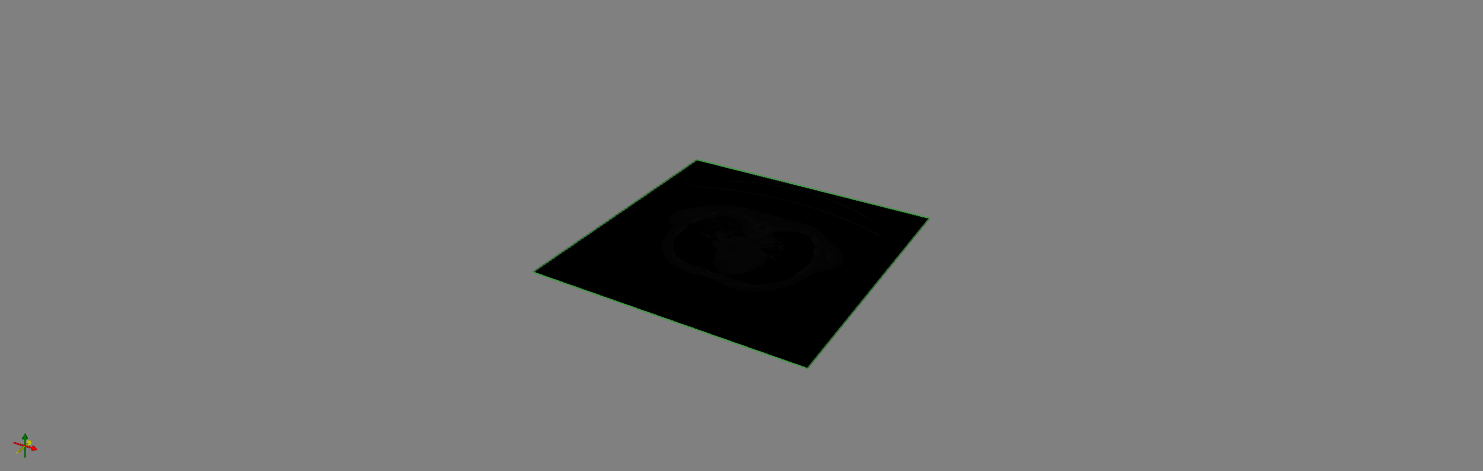
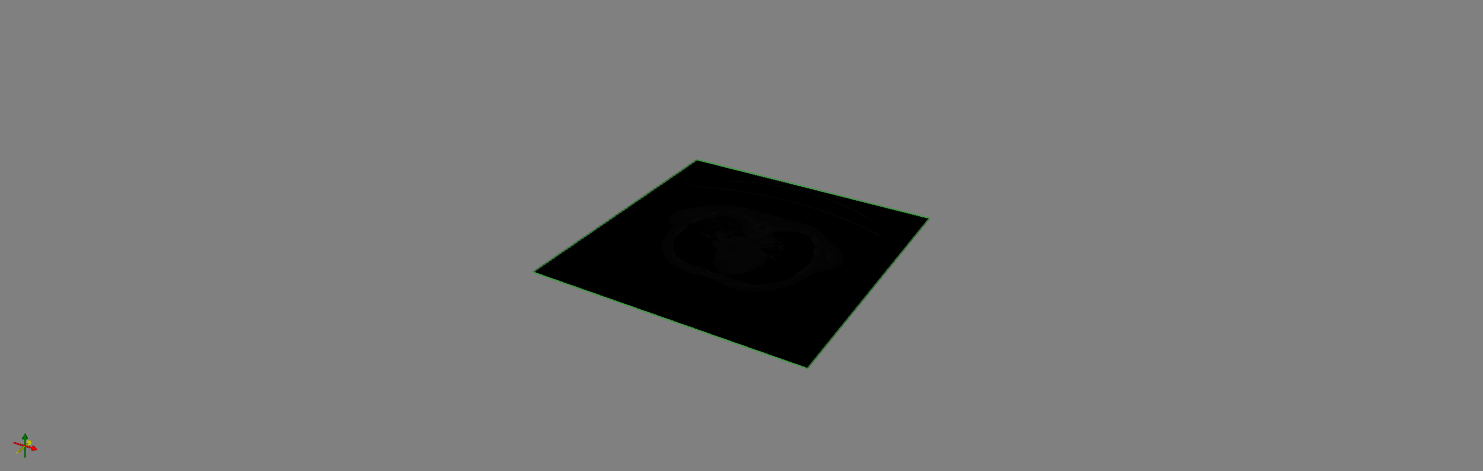

In [ ]:
viewerA = view(image=pro_ct_image, 
               label_image=pro_seg_image)


In [ ]:
viewerA.set_image_color_map("Grayscale")
viewerA.set_image_color_range([0,400])
viewerA.set_view_mode("ZPlane")
# viewerA.set_z_slice(53)
viewerA.set_ui_collapsed(False)

##### ITKWidgets with Nifti files

In [ ]:
# We need to convert our CT nifti and segmentation nifti files to ITK objects 

# print(nii_file)
# nii_file = '/content/ct.nii.gz'
ct_nii = nib.load('/content/ct.nii.gz') 
ct_data = ct_nii.get_fdata() 
ct_header = ct_nii.header 

ct_itk = itk.GetImageFromArray(ct_data) 
# ct_itk.SetOrigin(ct_header['origin'])
# ct_itk.SetSpacing(np.float32(ct_header['pixdim'][1:4]))
# ct_itk.SetDirection()

# itk_seg_image = itk.GetImageFromArray(itk_seg_obj.data.astype(np.float32))
# itk_seg_image.SetOrigin(itk_seg_obj.origin)
# itk_seg_image.SetSpacing(itk_seg_obj.spacing)
# itk_seg_image.SetDirection(itk_seg_obj.direction)

seg_nii = nib.load("/content/seg_dcmqi_resampled.nii.gz")
seg_data = seg_nii.get_fdata() 
seg_itk = itk.GetImageFromArray(seg_data)


In [ ]:
viewerB = view(image=ct_itk, 
               label_image=seg_itk)


In [ ]:
viewerB.set_image_color_map("Grayscale")
viewerB.set_ui_collapsed(False)
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(40)
viewerB.set_image_color_range([-1000,200]) # figure out good values later.

Both don't seem to be loading, downsample the images. 

In [ ]:
# We need to convert our CT nifti and segmentation nifti files to ITK objects 

ct_image_large = itk.imread("/content/raw", itk.F)

seg_nii = nib.load("/content/seg_dcmqi_resampled.nii.gz")
seg_data = seg_nii.get_fdata() 
seg_itk_large = itk.GetImageFromArray(seg_data)
seg_itk_large.CopyInformation(ct_image_large)

# # Do a rough downsampling to display 
# ct_data_downsampled = ct_data[::2,::2,::2]
# seg_data_downsampled = seg_data[::2,::2,::2]
# print('ct_data_downsampled: ' + str(ct_data_downsampled.shape))
# print('seg_data_downsampled: ' + str(seg_data_downsampled.shape))

# This data is huge, so to save time during demos, we subsample it in x and y dims:
new_spacing = list(ct_itk.GetSpacing())
new_spacing[:2] = [x*4 for x in new_spacing[:2]]
new_size = list(ct_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//4 for x in new_size[:2]]
ct_image = itk.resample_image_filter(Input=ct_image_large,
                                     output_spacing=new_spacing, 
                                     output_origin=ct_image_large.GetOrigin(), 
                                     output_direction=ct_image_large.GetDirection(),
                                     size=new_size)
labelmap_interpolator = itk.NearestNeighborInterpolateImageFunction.New(InputImage=seg_itk_large)
seg_itk = itk.resample_image_filter(Input=seg_itk_large,
                                    Interpolator=labelmap_interpolator,
                                    ReferenceImage=ct_image,
                                    UseReferenceImage=True)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")


New spacing = [4.0, 4.0, 1.0]
New size = [128, 128, 111]


In [ ]:
viewerB = view(image=ct_itk, 
               label_image=seg_itk)

In [ ]:
viewerB.set_image_color_map("Grayscale")
viewerB.set_ui_collapsed(False)
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(20)
viewerB.set_image_color_range([-1000,200]) # figure out good values later.

##### Custom code to overlay numpy arrays

In [ ]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils

from matplotlib.colors import ListedColormap

cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

In [ ]:
# Convert nii to nrrd for viz 
verbose = True 

log_file_path_nii = "/content/pypla.txt"
# convert_args_nii = {"input": "/content/raw", 
#                     "output-img": "/content/ct.nrrd"}
# pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

convert_args_nii = {"input": "/content/ct.nii.gz", 
                    "output-img": "/content/ct.nrrd"}
pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

if not os.path.isdir("/content/nrrd"): 
  os.mkdir("/content/nrrd")

for n in range(0,4): 
  input_img = os.path.join("/content/seg_converted_dcmqi_resampled", str(n+1)+".nii.gz")
  output_img = os.path.join("/content/nrrd", str(n+1)+".nrrd")
  convert_args_nii = {"input": input_img, 
                    "output-img": output_img}
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input /content/ct.nii.gz
  --output-img /content/ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/1.nii.gz
  --output-img /content/nrrd/1.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/2.nii.gz
  --output-img /content/nrrd/2.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/3.nii.gz
  --output-img /content/nrrd/3.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/4.nii.gz
  --output-img /content/nrrd/4.nrrd
... Done.


In [ ]:
# ct_data = nib.load("/content/ct.nii.gz").get_fdata() 
# print('ct_data: ' + str(ct_data.shape))

# pred_heart = nib.load("/content/seg_converted_dcmqi_resampled/2.nii.gz").get_fdata() 
# pred_aorta = nib.load("/content/seg_converted_dcmqi_resampled/4.nii.gz").get_fdata()
# pred_trachea = nib.load("/content/seg_converted_dcmqi_resampled/3.nii.gz").get_fdata()
# pred_esophagus = nib.load("/content/seg_converted_dcmqi_resampled/1.nii.gz").get_fdata()

# ct_data = np.rollaxis(ct_data, 2, 0)
# print('ct_data: ' + str(ct_data.shape))
# pred_heart = np.rollaxis(pred_heart, 2, 0); # pred_heart = np.swapaxes(pred_heart, 1, 2)
# pred_aorta = np.rollaxis(pred_aorta, 2, 0); # pred_aorta = np.swapaxes(pred_aorta, 1, 2)
# pred_trachea = np.rollaxis(pred_trachea, 2, 0); # pred_trachea = np.swapaxes(pred_trachea, 1, 2)
# pred_esophagus = np.rollaxis(pred_esophagus, 2, 0); # pred_esophagus = np.swapaxes(pred_esophagus, 1, 2)
# ct_data = np.swapaxes(ct_data, 1, 2)

In [ ]:
# _ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_data, 
#                                    segmask_dict = {"Heart" : pred_heart,
#                                                              "Aorta" : pred_aorta,
#                                                              "Trachea" : pred_trachea,
#                                                              "Esophagus" : pred_esophagus}, 
#                                    segmask_cmap_dict = {"Heart" : my_greens,
#                                                                "Aorta" : my_spring,
#                                                                "Esophagus" : my_reds,
#                                                                "Trachea" : my_blues}, 
#                                    dpi = 100)
ct_nrrd = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/ct.nrrd"), [False, True, False]))
pred_nrrd_heart = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/2.nrrd"), [False, True, False]))
pred_nrrd_aorta = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/4.nrrd"), [False, True, False]))
pred_nrrd_trachea = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/3.nrrd"), [False, True, False]))
pred_nrrd_esophagus = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/1.nrrd"), [False, True, False]))

_ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_nrrd, 
                                   segmask_dict = {"Heart" : pred_nrrd_heart,
                                                             "Aorta" : pred_nrrd_aorta,
                                                             "Trachea" : pred_nrrd_trachea,
                                                             "Esophagus" : pred_nrrd_esophagus}, 
                                   segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Aorta" : my_spring,
                                                               "Esophagus" : my_reds,
                                                               "Trachea" : my_blues}, 
                                   dpi = 100)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## Radiomics SR analysis

The second part of the nnU-Net analysis is to interact with the radiomics features that were extracted from each of the predicted regions. 

### Extract a single feature for one subject and all regions

Here we demonstrate how to first extract a single 3D radiomic shape features for one series and all regions. We query to first get the SeriesInstanceUIDs that have expert segmentations, order them and pick the first one, and then get the corresponding sphericity features that correspond to that series.  

In [ ]:
client = bigquery.Client(project=project_name)

query = f"""

    # We want the SeriesInstanceUIDS of the ones that have manual (expert segmentations)
    WITH seg_series AS(
      SELECT 
        DISTINCT(SOPInstanceUID) as SOPInstanceUID,  
        SeriesDescription, 
        ReferencedSeriesSequence[OFFSET(0)].SeriesInstanceUID as ref_SeriesInstanceUID 
      FROM
        `bigquery-public-data.idc_v13.dicom_all` as dicom_all
      WHERE
        source_DOI = '10.7937/K9/TCIA.2015.PF0M9REI' AND
        Modality = "SEG"
      ORDER BY 
        SOPInstanceUID 
      LIMIT 1 # we just want a single series
    ) 

    # Then we want to get all the measurements associated with those referenced SeriesInstanceUIDs 
    SELECT 
      seg_series.SOPInstanceUID, 
      seg_series.ref_SeriesInstanceUID, 
      quant_table.SeriesDescription,
      quant_table.findingSite.CodeMeaning as region,  
      quant_table.Value  
    FROM
      seg_series 
    JOIN 
      `bigquery-public-data.idc_v13.quantitative_measurements` as quant_table 
    ON
      quant_table.sourceSegmentedSeriesUID = seg_series.ref_SeriesInstanceUID 
    WHERE
      Quantity[OFFSET(0)].CodeMeaning = "Sphericity"
    ORDER BY 
      seg_series.ref_SeriesInstanceUID, 
      seg_series.SOPInstanceUID, 
      quant_table.SeriesDescription,
      quant_table.findingSite.CodeMeaning

  """ 

radiomics_single_series_df = client.query(query).to_dataframe()

In [ ]:
radiomics_single_series_df

SOPInstanceUID  \
0   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
1   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
2   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
3   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
4   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
5   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
6   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
7   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
8   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
9   1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
10  1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
11  1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   
12  1.2.276.0.7230010.3.1.4.2323910823.10112.15972...   

                                ref_SeriesInstanceUID  \
0   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
1   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
2   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
3   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
4   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
5   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
6   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
7   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
8   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
9   1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
10  1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
11  1.3.6.1.4.1.32722.99.99.1778530212264410538017...   
12  1.3.6.1.4.1.32722.99.99.1778530212264410538017...   

                      SeriesDescription     region        Value  
0           2d-tta_nnU-Net_Measurements      Aorta  0.508000000  
1           2d-tta_nnU-Net_Measurements  Esophagus  0.383000000  
2           2d-tta_nnU-Net_Measurements      Heart  0.755000000  
3           2d-tta_nnU-Net_Measurements    Trachea  0.505000000  
4   3d_fullres-tta_nnU-Net_Measurements      Aorta  0.509000000  
5   3d_fullres-tta_nnU-Net_Measurements  Esophagus  0.387000000  
6   3d_fullres-tta_nnU-Net_Measurements      Heart  0.802000000  
7   3d_fullres-tta_nnU-Net_Measurements    Trachea  0.488000000  
8    3d_lowres-tta_nnU-Net_Measurements      Aorta  0.494000000  
9    3d_lowres-tta_nnU-Net_Measurements  Esophagus  0.381000000  
10   3d_lowres-tta_nnU-Net_Measurements      Heart  0.789000000  
11   3d_lowres-tta_nnU-Net_Measurements    Trachea  0.474000000  
12    Manual_segmentations_Measurements  Esophagus  0.360000000

For each region, let's plot a bar chart of the features for expert and 3 AI-derived models. We can see that only the expert segmenations are present for the Esophagus. 

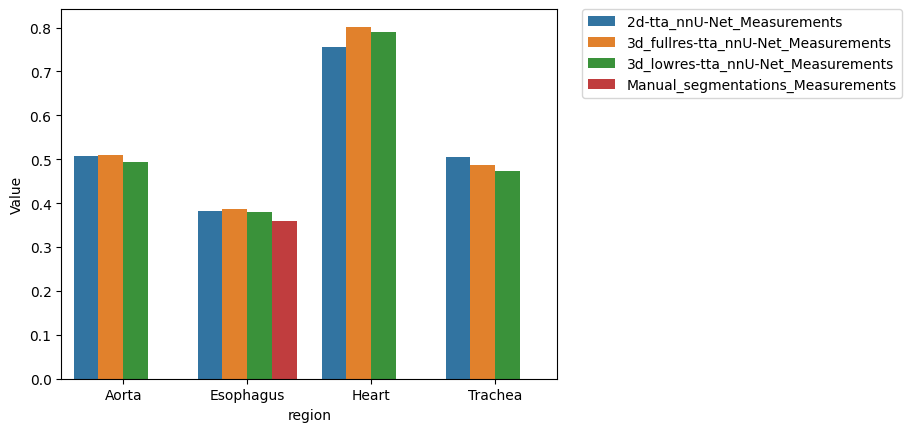

In [ ]:
sns.barplot(data=radiomics_single_series_df, x="region", y="Value", hue="SeriesDescription")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Extract all series that have a feature within a certain range

Another test that we can do is to to obtain a list of series that have a specific feature within a certain range. We can get a list of OHIF viewer links and visually assess the patients. Here we will look at the NLST patients and search for those with sphericity values > 0.3 and less than 0.4 for the 

In [ ]:
# Query to get a single feature for all regions 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'quantitative_measurements'])
print(table_id)

query = f"""
WITH source_ids AS (

SELECT 
  sourceSegmentedSeriesUID,
  SeriesDescription,
  findingSite.CodeMeaning as findingSite,
  Value
FROM 
  `bigquery-public-data.idc_v13.quantitative_measurements` 
WHERE
  findingSite.CodeMeaning = "Heart" AND
  Quantity[OFFSET(0)].CodeMeaning = "Sphericity" AND 
  Value >= 0.7 AND 
  Value <= 0.8
) 

SELECT 
  DISTINCT(source_ids.sourceSegmentedSeriesUID),
  dicom_all.StudyInstanceUID,
  source_ids.SeriesDescription,
  dicom_all.collection_id, 
  source_ids.findingSite, 
  source_ids.Value,
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url
FROM 
  source_ids 
JOIN 
  `bigquery-public-data.idc_v13.dicom_all` as dicom_all 
ON 
  source_ids.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nlst"
ORDER BY 
   source_ids.Value

""" 

feature_df = client.query(query).to_dataframe()


bigquery-public-data.idc_v13.quantitative_measurements


Now we can open up the OHIF viewer link 

In [ ]:
feature_df.head()

sourceSegmentedSeriesUID  \
0  1.2.840.113654.2.55.83156031026770571931724954...   
1  1.2.840.113654.2.55.13302426608339249022725888...   
2  1.2.840.113654.2.55.31113544885931756877241156...   
3  1.2.840.113654.2.55.25398246706143228739120241...   
4  1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529...   

                                    StudyInstanceUID  \
0  1.2.840.113654.2.55.26656060284884261615283842...   
1  1.2.840.113654.2.55.83520557178146648628754360...   
2  1.2.840.113654.2.55.29214645567755420322416812...   
3  1.2.840.113654.2.55.32280588970386660475901891...   
4  1.3.6.1.4.1.14519.5.2.1.7009.9004.244100604207...   

                     SeriesDescription collection_id findingSite        Value  \
0  3d_fullres-tta_nnU-Net_Measurements          nlst       Heart  0.758000000   
1  3d_fullres-tta_nnU-Net_Measurements          nlst       Heart  0.762000000   
2  3d_fullres-tta_nnU-Net_Measurements          nlst       Heart  0.762000000   
3  3d_fullres-tta_nnU-Net_Measurements          nlst       Heart  0.763000000   
4  3d_fullres-tta_nnU-Net_Measurements          nlst       Heart  0.764000000   

                                          viewer_url  
0  https://viewer.imaging.datacommons.cancer.gov/...  
1  https://viewer.imaging.datacommons.cancer.gov/...  
2  https://viewer.imaging.datacommons.cancer.gov/...  
3  https://viewer.imaging.datacommons.cancer.gov/...  
4  https://viewer.imaging.datacommons.cancer.gov/...

### (paper figure #6) NSCLC Radiomics - Extract a single feature for all subjects and a single region

We also demonstrate how to extract a single feature for all subjects for a single region. We then plot the distributions of the features for the manual segmentations and the three nnU-Net predicted models. We link the OHIF viewer to further investigate any possible outliers.

In [ ]:
# Query to get a single feature for all series for a single region

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'quantitative_measurements']) 
print(table_id)

region = "Heart"

query = f"""
WITH features AS (

  SELECT 
    sourceSegmentedSeriesUID, 
    SOPInstanceUID, 
    SeriesDescription, 
    Value  
  FROM 
    `bigquery-public-data.idc_v13.quantitative_measurements` 
  WHERE
    Quantity[OFFSET(0)].CodeMeaning = "Sphericity" AND 
    findingSite.CodeMeaning = @region
)

SELECT 
  DISTINCT(features.sourceSegmentedSeriesUID), 
  features.SOPInstanceUID, 
  dicom_all.StudyInstanceUID, 
  dicom_all.PatientID, 
  features.SeriesDescription, 
  features.Value,
  # CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",features.sourceSegmentedSeriesUID) as viewer_url 
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url 

FROM 
  features
LEFT JOIN 
  `bigquery-public-data.idc_v13.dicom_all` as dicom_all 
ON 
  features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nsclc_radiomics" 
ORDER BY 
  dicom_all.PatientID, 
  dicom_all.StudyInstanceUID,
  features.sourceSegmentedSeriesUID,
  features.SeriesDescription
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
radiomics_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_v13.quantitative_measurements


In [ ]:
###########################################################
# --- Create a plot for the feature --- #
###########################################################

#--- create df of the feature we want to plot ---# 

df_plot = radiomics_df
new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
num_SeriesDescriptions = len(SeriesDescriptions_list)
print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

#--- Plot using bokeh ---# 

output_notebook()

hover = HoverTool(tooltips=[
  (''.join(["(",'Sphericity',")"]), "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'SeriesDescription')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
SeriesDescriptions = colormap_list_keys 
print('SeriesDescriptions: ' + str(SeriesDescriptions))

cats = df_plot.SeriesDescription.unique()
print('cats: ' + str(cats))

colors = list(colormap.values())
print('colors: ' + str(colors))

cats2 = [] 
for c in range(0,len(cats)): 
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2
print('cats2: ' + str(cats2))
print('regions: ' + str(regions)) 

colors2 = [] 
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
          title='Sphericity')

l = p.circle(y='Value_numeric', x=jitter('SeriesDescription', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

legend = Legend(items=[LegendItem(label=dict(field="SeriesDescription"), renderers=[l])])

p.add_layout(legend, 'below')  

### Include the box plots ### 
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['SeriesDescription2'] = [str(f) + '_boxplot' for f in list(df_plot['SeriesDescription'].values)]

# regions are in order we want 
category_SeriesDescription = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['SeriesDescription2'] = df_plot2['SeriesDescription2'].astype(category_SeriesDescription)

groups = df_plot2.groupby('SeriesDescription2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2,
    bottom=q2.Value_numeric,
    top=q3.Value_numeric, 
    fill_color=colors2,
    legend=cats2
))

lower_source = ColumnDataSource(data=dict(
    x=cats2,
    bottom=q1.Value_numeric, 
    top=q2.Value_numeric,
    fill_color=colors2
))


# stems (Don't need colors of treatment)
p.segment(cats2, upper.Value_numeric, cats2, q3.Value_numeric, line_color="black")
p.segment(cats2, lower.Value_numeric, cats2, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats2, lower.Value_numeric, 0.2, 0.0001, line_color="black")
p.rect(cats2, upper.Value_numeric, 0.2, 0.0001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

# Setup plot titles and such.
p.title.text = 'Sphericity'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label = "Model type"
p.yaxis.axis_label="Sphericity"
# p.legend.location = (100,10)

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

num_SeriesDescriptions: 4
colormap: {'2d-tta_nnU-Net_Measurements': '#1b9e77', '3d_fullres-tta_nnU-Net_Measurements': '#d95f02', '3d_lowres-tta_nnU-Net_Measurements': '#7570b3', 'Manual_segmentations_Measurements': '#e7298a'}
colormap_list_keys: ['2d-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
SeriesDescriptions: ['2d-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
cats: ['2d-tta_nnU-Net_Measurements' '3d_fullres-tta_nnU-Net_Measurements'
 '3d_lowres-tta_nnU-Net_Measurements' 'Manual_segmentations_Measurements']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
cats2: ['2d-tta_nnU-Net_Measurements', '2d-tta_nnU-Net_Measurements_boxplot', '3d_fullres-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements_boxplot', '3d_lowres-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements_b

### **(paper figure #7)** NLST - Extract a single feature for all subjects and a single region

For the NLST collection, as we do not have expert segmentations, we can plot a single feature across all four regions. Here we pick the Sphericity feature and plot the values across all series. 

Let's first query to get the dataframe we need for plotting. This is the same query as before, but with a different collection_id. 

In [ ]:
# Query to get a single feature for all series for a single region

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'quantitative_measurements']) 
print(table_id)

query = f"""
WITH features AS (

  SELECT 
    sourceSegmentedSeriesUID, 
    SOPInstanceUID, 
    SeriesDescription, 
    findingSite.CodeMeaning as region, 
    Value  
  FROM 
    `bigquery-public-data.idc_v13.quantitative_measurements` 
  WHERE
    Quantity[OFFSET(0)].CodeMeaning = "Sphericity"
)

SELECT 
  DISTINCT(features.sourceSegmentedSeriesUID), 
  features.SOPInstanceUID, 
  dicom_all.StudyInstanceUID, 
  dicom_all.PatientID, 
  features.SeriesDescription, 
  features.region,
  features.Value,
  # CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",features.sourceSegmentedSeriesUID) as viewer_url 
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url 

FROM 
  features
LEFT JOIN 
  `bigquery-public-data.idc_v13.dicom_all` as dicom_all 
ON 
  features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nlst" 
ORDER BY 
  dicom_all.PatientID, 
  features.sourceSegmentedSeriesUID 
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
df_plot = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.quantitative_measurements


Now we use use bokeh to plot like before.

In [ ]:

#--- create df of the feature we want to plot ---# 

new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

#### for each feature ### 

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'region')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Value)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# cats = list(df_plot.region.unique()) # had to add list to this.
cats = regions 
print('cats: ' + str(cats))
print('regions: ' + str(regions))

cats2 = [] 
for c in range(0,len(cats)): 
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2
print('cats2: ' + str(cats2))
print('regions: ' + str(regions)) 

colors2 = [] 
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

# regions are in order we want 
p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          x_range=regions,
          # x_range=cats, 
          title="Shape feature value")

l = p.circle(y='Value_numeric', x=jitter('region', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')
legend = Legend(items=[LegendItem(label=dict(field="region"), renderers=[l])])

p.add_layout(legend, 'below')    


### Include the box plots ### 
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['region2'] = [f + '_boxplot' for f in df_plot['region'].values]

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['region2'] = df_plot2['region2'].astype(category_region)

groups = df_plot2.groupby('region2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q2.Value_numeric,
    top=q3.Value_numeric,
    fill_color=colors2,
    legend=cats2
))

lower_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q1.Value_numeric,
    top=q2.Value_numeric,
    fill_color=colors2
))


# stems (Don't need colors of treatment)
p.segment(cats2, upper.Value_numeric, cats2, q3.Value_numeric, line_color="black")
p.segment(cats2, lower.Value_numeric, cats2, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats2, lower.Value_numeric, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats2, upper.Value_numeric, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

# Setup plot titles and such.
p.title.text = "Sphericity"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Sphericity"
p.legend.location = (100,10)

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

########
# p.legend.visible=False 

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'Trachea': '#1b9e77', 'Esophagus': '#d95f02', 'Heart': '#7570b3', 'Aorta': '#e7298a'}
colormap_list_keys: ['Trachea', 'Esophagus', 'Heart', 'Aorta']
regions: ['Trachea', 'Esophagus', 'Heart', 'Aorta']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
cats: ['Trachea', 'Esophagus', 'Heart', 'Aorta']
regions: ['Trachea', 'Esophagus', 'Heart', 'Aorta']
cats2: ['Trachea', 'Trachea_boxplot', 'Esophagus', 'Esophagus_boxplot', 'Heart', 'Heart_boxplot', 'Aorta', 'Aorta_boxplot']
regions: ['Trachea', 'Trachea_boxplot', 'Esophagus', 'Esophagus_boxplot', 'Heart', 'Heart_boxplot', 'Aorta', 'Aorta_boxplot']


### Download and read

Here we download and read the radiomics feature SRs using dcmqi and highdicom software packages.

#### Download a DICOM Structured Report for one subject

To download the DICOM Structured Report containing the radiomics features information, we need the gcs_url. We will choose a patient from the dataframe `radiomics_df` created in the (paper figure #6) section. 

In [ ]:
radiomics_df

sourceSegmentedSeriesUID  \
0     1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
1     1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
2     1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
3     1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
4     1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
...                                                 ...   
1359  1.3.6.1.4.1.32722.99.99.3051646366712319699947...   
1360  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
1361  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
1362  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
1363  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   

                                         SOPInstanceUID  \
0     1.2.276.0.7230010.3.1.4.481034752.468135.16657...   
1     1.2.276.0.7230010.3.1.4.481034752.147481.16643...   
2     1.2.276.0.7230010.3.1.4.481034752.183145.16656...   
3     1.2.276.0.7230010.3.1.4.481034752.398774.16657...   
4     1.2.276.0.7230010.3.1.4.481034752.68590.166429...   
...                                                 ...   
1359  1.2.276.0.7230010.3.1.4.481037312.83556.167149...   
1360  1.2.276.0.7230010.3.1.4.481034752.401483.16657...   
1361  1.2.276.0.7230010.3.1.4.481034752.71671.166429...   
1362  1.2.276.0.7230010.3.1.4.481034752.115316.16656...   
1363  1.2.276.0.7230010.3.1.4.481037312.52493.167148...   

                                       StudyInstanceUID  PatientID  \
0     1.3.6.1.4.1.32722.99.99.2393413539117143687725...  LUNG1-001   
1     1.3.6.1.4.1.32722.99.99.2393413539117143687725...  LUNG1-001   
2     1.3.6.1.4.1.32722.99.99.2393413539117143687725...  LUNG1-001   
3     1.3.6.1.4.1.32722.99.99.2037150038059966416957...  LUNG1-002   
4     1.3.6.1.4.1.32722.99.99.2037150038059966416957...  LUNG1-002   
...                                                 ...        ...   
1359  1.3.6.1.4.1.32722.99.99.9487282134711408248112...  LUNG1-421   
1360  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   
1361  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   
1362  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   
1363  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   

                        SeriesDescription        Value  \
0             2d-tta_nnU-Net_Measurements  0.744000000   
1     3d_fullres-tta_nnU-Net_Measurements  0.797000000   
2      3d_lowres-tta_nnU-Net_Measurements  0.788000000   
3             2d-tta_nnU-Net_Measurements  0.761000000   
4     3d_fullres-tta_nnU-Net_Measurements  0.784000000   
...                                   ...          ...   
1359    Manual_segmentations_Measurements  0.748000000   
1360          2d-tta_nnU-Net_Measurements  0.771000000   
1361  3d_fullres-tta_nnU-Net_Measurements  0.788000000   
1362   3d_lowres-tta_nnU-Net_Measurements  0.766000000   
1363    Manual_segmentations_Measurements  0.673000000   

                                             viewer_url  Value_numeric  \
0     https://viewer.imaging.datacommons.cancer.gov/...          0.744   
1     https://viewer.imaging.datacommons.cancer.gov/...          0.797   
2     https://viewer.imaging.datacommons.cancer.gov/...          0.788   
3     https://viewer.imaging.datacommons.cancer.gov/...          0.761   
4     https://viewer.imaging.datacommons.cancer.gov/...          0.784   
...                                                 ...            ...   
1359  https://viewer.imaging.datacommons.cancer.gov/...          0.748   
1360  https://viewer.imaging.datacommons.cancer.gov/...          0.771   
1361  https://viewer.imaging.datacommons.cancer.gov/...          0.788   
1362  https://viewer.imaging.datacommons.cancer.gov/...          0.766   
1363  https://viewer.imaging.datacommons.cancer.gov/...          0.673   

       colors  
0     #1b9e77  
1     #d95f02  
2     #7570b3  
3     #1b9e77  
4     #d95f02  
...       ...  
1359  #e7298a  
1360  #1b9e77  
1361  #d95f02  
1362  #7570b3  
1363  #e72

In [ ]:
# Pick a single Radiomics SR from previous df 

SOPInstanceUID = radiomics_df['SOPInstanceUID'].values[0]
SOPInstanceUID

'1.2.276.0.7230010.3.1.4.481034752.468135.1665722540.260168'

In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_v13.dicom_all


In [ ]:
sr_df

SeriesDescription  \
0  2d-tta_nnU-Net_Measurements   

                                             gcs_url  
0  gs://public-datasets-idc/4344dae8-58de-4f8e-8c...

In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm...
/ [1/1 files][168.3 KiB/168.3 KiB] 100% Done                                    
Operation completed over 1 objects/168.3 KiB.                                    
/content/sr/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm
/content/sr/sr.dcm


'/content/sr/sr.dcm'

#### Read using dcmqi

We will first demonstrate how to read all of the metadata using `dcmqi`'s `tid1500reader`. 

In [ ]:
output_directory_sr_features_converted_dcmqi = "/content/sr_features_dcmqi"
if not os.path.isdir(output_directory_sr_features_converted_dcmqi): 
  os.mkdir(output_directory_sr_features_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_features_converted_dcmqi, "sr_features.json")

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_features_json = json.load(f)
sr_features_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'Finding': {'CodeMeaning': 'Organ',
    'CodeValue': '113343008',
    'CodingSchemeDesignator': 'SCT'},
   'FindingSite': {'CodeMeaning': 'Esophagus',
    'CodeValue': '32849002',
    'CodingSchemeDesignator': 'SCT'},
   'ReferencedSegment': 1,
   'SourceSeriesForImageSegmentation': '1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046',
   'TrackingIdentifier': 'Measurements group 1',
   'TrackingUniqueIdentifier': '1.3.6.1.4.1.43046.3.1.4.481034752.468135.1665722540.260164',
   'activitySession': '1',
   'measurementItems': [{'measurementAlgorithmIdentification': {'AlgorithmName': 'pyradiomics',
      'AlgorithmVersion': 'v3.0.1'},
     'quantity': {'CodeMeaning': 'Elongation',
      'CodeValue': 'Q3CK',
      'CodingSchemeDesignator': 'IBSI'},
     'units': {'CodeMeaning': 'millimeter',
      'CodeValue': 'mm',
      'CodingSchemeDesignator': 'UCUM'},
     'value': '0.187'},
    {'measurementAlgorit

#### Read using highdicom

Next we will demonstrate how to read the important fields using the `highdicom` software package. 

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

features_sr_df = pd.DataFrame() 

segment_names = [] 
segment_numbers = [] 

feature_name_values = [] 
feature_name_codes = [] 
feature_name_meanings = [] 

feature_unit_values = [] 
feature_unit_codes = [] 
feature_unit_meanings = [] 

values = [] 
ref_seg_sop_ids = [] 

features_sr_df = pd.DataFrame() 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS,
    value_type=ValueTypeValues.CONTAINER,
    name=codes.DCM.ImagingMeasurements
)

containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS
)
num_segments = len(containers_level2)
print('num_segments: ' + str(num_segments))

for segment_index in range(0,num_segments): 

  print('segment_index: ' + str(segment_index))

  # For each segment in num_segments, get the segment_name, segment_number, and referencedsegmentSOPInstanceUID  
  containers_level2A = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD,
      value_type=ValueTypeValues.CODE
  )

  # segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  # segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  # print('   segment_name: ' + str(segment_name))

  containers_level3A = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.CONTAINS,
      value_type=ValueTypeValues.IMAGE
  )

  segment_number = containers_level3A[0].ReferencedSOPSequence[0].ReferencedSegmentNumber
  ref_seg_sop_id = containers_level3A[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  # print('   segment_number: ' + str(segment_number))
  # print('   ref_seg_sop_id: ' + str(ref_seg_sop_id))

  ### The below works, just need to get segment info first ### 
  containers_level3 = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.CONTAINS,
      value_type=ValueTypeValues.NUM
  )
  num_features = len(containers_level3)
  # print('   num_features: ' + str(num_features))

  for feature_index in range(0,num_features):

    feature_name_value = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodeValue'].value
    feature_name_code = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodingSchemeDesignator'].value
    feature_name_meaning = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodeMeaning'].value
    # print('      feature_name_value: ' + str(feature_name_value) + ' feature_name_code: ' + str(feature_name_code) + 'feature_name_meaning: ' + str(feature_name_meaning))

    feature_unit_value = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodeValue'].value
    feature_unit_code = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodingSchemeDesignator'].value
    feature_unit_meaning = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodeMeaning'].value
    # print('      feature_unit_value: ' + str(feature_unit_value) + ' feature_unit_code: ' + str(feature_unit_code) + 'feature_unit_meaning: ' + str(feature_unit_meaning))

    value = containers_level3[feature_index].MeasuredValueSequence[0].NumericValue
    # print('      value: ' + str(value))

    # Append for all 
    segment_numbers.append(segment_number)
    segment_names.append(segment_name)
    feature_name_values.append(feature_name_value)
    feature_name_codes.append(feature_name_code) 
    feature_name_meanings.append(feature_name_meaning)
    feature_unit_values.append(feature_unit_value) 
    feature_unit_codes.append(feature_unit_code)
    feature_unit_meanings.append(feature_unit_meaning)
    values.append(value)
    ref_seg_sop_ids.append(ref_seg_sop_id)



# Form dataframe 

features_sr_df['segment_number'] = segment_numbers 
features_sr_df['segment_name'] = segment_name

features_sr_df['feature_name_value'] = feature_name_values 
features_sr_df['feature_name_code'] = feature_name_codes 
features_sr_df['feature_name_meaning'] = feature_name_meanings

features_sr_df['feature_unit_value'] = feature_unit_values 
features_sr_df['feature_unit_code'] = feature_unit_codes
features_sr_df['features_unit_meaning'] = feature_unit_meanings 

features_sr_df['value'] = values 

features_sr_df['ref_sop_id'] = ref_seg_sop_ids 

features_sr_df 

sr_file: /content/sr/sr.dcm
num_segments: 4
segment_index: 0
segment_index: 1
segment_index: 2
segment_index: 3


segment_number segment_name feature_name_value feature_name_code  \
0                1        Aorta               Q3CK              IBSI   
1                1        Aorta               N17B              IBSI   
2                1        Aorta               7J51              IBSI   
3                1        Aorta               TDIC              IBSI   
4                1        Aorta               L0JK              IBSI   
5                1        Aorta               RNU0              IBSI   
6                1        Aorta               P9VJ              IBSI   
7                1        Aorta               QCFX              IBSI   
8                1        Aorta               C0JK              IBSI   
9                1        Aorta               2PR5              IBSI   
10               1        Aorta               YEKZ              IBSI   
11               1        Aorta               SKGS              IBSI   
12               1        Aorta               BQWJ              IBSI   
13               1        Aorta               KRCK              IBSI   
14               2        Aorta               Q3CK              IBSI   
15               2        Aorta               N17B              IBSI   
16               2        Aorta               7J51              IBSI   
17               2        Aorta               TDIC              IBSI   
18               2        Aorta               L0JK              IBSI   
19               2        Aorta               RNU0              IBSI   
20               2        Aorta               P9VJ              IBSI   
21               2        Aorta               QCFX              IBSI   
22               2        Aorta               C0JK              IBSI   
23               2        Aorta               2PR5              IBSI   
24               2        Aorta               YEKZ              IBSI   
25               2        Aorta               SKGS              IBSI   
26               2        Aorta               BQWJ              IBSI   
27               2        Aorta               KRCK              IBSI   
28               3        Aorta               Q3CK              IBSI   
29               3        Aorta               N17B              IBSI   
30               3        Aorta               7J51              IBSI   
31               3        Aorta               TDIC              IBSI   
32               3        Aorta               L0JK              IBSI   
33               3        Aorta               RNU0              IBSI   
34               3        Aorta               P9VJ              IBSI   
35               3        Aorta               QCFX              IBSI   
36               3        Aorta               C0JK              IBSI   
37               3        Aorta               2PR5              IBSI   
38               3        Aorta               YEKZ              IBSI   
39               3        Aorta               SKGS              IBSI   
40               3        Aorta               BQWJ              IBSI   
41               3        Aorta               KRCK              IBSI   
42               4        Aorta               Q3CK              IBSI   
43               4        Aorta               N17B              IBSI   
44               4        Aorta               7J51              IBSI   
45               4        Aorta               TDIC              IBSI   
46               4        Aorta               L0JK              IBSI   
47               4        Aorta               RNU0              IBSI   
48               4        Aorta               P9VJ              IBSI   
49               4        Aorta               QCFX              IBSI   
50               4        Aorta               C0JK              IBSI   
51               4        Aorta               2PR5              IBSI   
52               4        Aorta               YEKZ              IBSI   
53               4        Aorta               SKGS              IBSI   
54               4        Aorta             

# Body Part Prediction results analysis

The second part of the analysis is from the Body Part Regression approach. To capture the results of this model, we created two structured reports for each series analyzed. The first is a landmarks SR which contains information about each landmark and which axial slice is it assigned to. The second is a regions SR which contains information about the region(s) assigned to each axial slice. 

## Landmarks analysis

First we focus on the analysis of the landmarks SR.

### **(paper figure #3)** NSCLC-Radiomics - Query and extract values from the landmarks SR and create plot of coronal slice

We first get a list of all the possible landmarks from the csv file. 

In [ ]:
!wget -N https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
landmarks_df = pd.read_csv("bpr_landmarks_code_mapping.csv")

--2023-04-07 19:10:24--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797 (1.8K) [text/plain]
Saving to: ‘bpr_landmarks_code_mapping.csv’

bpr_landmarks_code_ 100%[===================>]   1.75K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-04-07 19:10:25 (23.3 MB/s) - ‘bpr_landmarks_code_mapping.csv’ saved [1797/1797]



We then need to download the public BPR model from Zenodo and get the inference-settings.json file as we need the ordering of the landmarks from inferior to superior. 

In [ ]:
bpr_model_url = "https://zenodo.org/record/5113483/files/public_bpr_model.zip"
model_download_path = "/content/models/bpr_model.zip"
if not os.path.isdir("/content/models"):
  os.mkdir("/content/models")

!wget -O $model_download_path $bpr_model_url 

model_extract_path = "/content/models/bpr_model"
!unzip $model_download_path -d $model_extract_path

--2023-04-07 19:10:27--  https://zenodo.org/record/5113483/files/public_bpr_model.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55645041 (53M) [application/octet-stream]
Saving to: ‘/content/models/bpr_model.zip’

/content/models/bpr 100%[===================>]  53.07M  6.91MB/s    in 60s     

2023-04-07 19:11:29 (911 KB/s) - ‘/content/models/bpr_model.zip’ saved [55645041/55645041]

Archive:  /content/models/bpr_model.zip
   creating: /content/models/bpr_model/public_bpr_model/
  inflating: /content/models/bpr_model/public_bpr_model/reference.xlsx  
  inflating: /content/models/bpr_model/public_bpr_model/inference-settings.json  
  inflating: /content/models/bpr_model/public_bpr_model/model.pt  
  inflating: /content/models/bpr_model/public_bpr_model/config.json  


Let's get the data from the inference-settings.json file. 

In [ ]:
inference_settings_file = "/content/models/bpr_model/public_bpr_model/inference-settings.json" 
with open(inference_settings_file) as f: 
  inference_settings_json = json.load(f)

landmarks_inference = inference_settings_json['lookuptable_train_val']['transformed']

# create new dictionary with ordered landmarks 
landmarks_inference_sorted = dict(sorted(landmarks_inference.items(), key=lambda item: item[1]['mean'])) 

Now let's create a dataframe that will include data from the inference-settings.json along with the codes that we use to describe the landmarks in the DICOM Structured Reports.

In [ ]:
# Create a dataframe with the landmarks_inference_sorted 

landmarks_inference_sorted_df = pd.DataFrame() 
landmarks_inference_sorted_df['landmark'] = landmarks_inference_sorted.keys() 
landmarks_inference_sorted_df['mean'] = [landmarks_inference_sorted[f]['mean'] for f in landmarks_inference_sorted.keys()]
landmarks_inference_sorted_df['std'] = [landmarks_inference_sorted[f]['std'] for f in landmarks_inference_sorted.keys()]

# To this dataframe we add the corresponding fields from landmarks_df, in the correct order
num_codes = len(landmarks_inference_sorted_df)
landmark_CodeMeanings = [] 
modifier_CodeMeanings = [] 

# for each 
for n in range(0,num_codes): 
  bpr_code = landmarks_inference_sorted_df['landmark'].values[n]
  landmark_CodeMeaning = landmarks_df[landmarks_df['BPR_code']==bpr_code]['CodeMeaning'].values[0]
  modifier_CodeMeaning = landmarks_df[landmarks_df['BPR_code']==bpr_code]['modifier_CodeMeaning'].values[0]
  landmark_CodeMeanings.append(landmark_CodeMeaning)
  modifier_CodeMeanings.append(modifier_CodeMeaning)

landmarks_inference_sorted_df['landmark_CodeMeaning'] = landmark_CodeMeanings 
landmarks_inference_sorted_df['modifier_CodeMeaning'] = modifier_CodeMeanings 
landmarks_inference_sorted_df['landmark_and_modifier_name'] = [f + ' ' + g for f,g in zip(landmark_CodeMeanings,modifier_CodeMeanings)]

In [ ]:
landmarks_inference_sorted_df

landmark     mean    std                   landmark_CodeMeaning  \
0   pelvis_start    0.000  1.983                                 Pelvis   
1      femur_end   13.616  1.198                                  Femur   
2             L5   25.532  1.854                            L5 vertebra   
3     pelvis_end   28.824  1.881                                 Pelvis   
4             L4   29.414  2.098                            L4 vertebra   
5             L3   33.817  2.290                            L3 vertebra   
6         kidney   37.597  4.116                                 Kidney   
7             L2   37.763  2.335                            L2 vertebra   
8             L1   41.478  2.276                            L1 vertebra   
9     lung_start   44.143  4.385                                   Lung   
10          Th12   44.952  2.287                           T12 vertebra   
11          Th11   47.725  2.503                           T11 vertebra   
12          Th10   51.069  2.717                           T10 vertebra   
13           Th9   53.994  2.613                            T9 vertebra   
14     liver_end   54.479  3.986                                  Liver   
15           Th8   56.856  2.360                            T8 vertebra   
16           Th7   59.851  2.822                            T7 vertebra   
17           Th6   63.177  2.404                            T6 vertebra   
18           Th5   65.964  2.118                            T5 vertebra   
19           Th4   68.499  2.051                            T4 vertebra   
20           Th3   70.973  2.038                            T3 vertebra   
21           Th2   73.401  1.694                            T2 vertebra   
22      lung_end   75.389  1.478                                   Lung   
23           Th1   75.794  1.811                            T1 vertebra   
24            C7   77.937  1.849                            C7 vertebra   
25            C6   79.497  1.637                            C6 vertebra   
26            C5   81.826  1.527                            C5 vertebra   
27            C4   83.817  1.378                            C4 vertebra   
28            C3   85.647  1.472                            C3 vertebra   
29         teeth   86.908  3.253  Teeth, gums and supporting structures   
30            C2   87.206  1.327                            C2 vertebra   
31            C1   89.234  1.397                            C1 vertebra   
32          nose   92.567  5.355                                   Nose   
33      eyes_end  100.000  3.789                                    Eye   
34      head_end  107.756  1.785                                   Head   

   modifier_CodeMeaning                    landmark_and_modifier_name  
0                Bottom                                 Pelvis Bottom  
1                   Top                                     Femur Top  
2                Center                            L5 vertebra Center  
3                   Top                                    Pelvis Top  
4                Center                            L4 vertebra Center  
5                Center                            L3 vertebra Center  
6                Bottom                                 Kidney Bottom  
7                Center                            L2 vertebra Center  
8                Center                            L1 vertebra Center  
9                Bottom                                   Lung Bottom  
10               Center                           T12 vertebra Center  
11               Center                           T11 vertebra Center  
12               Center                           T10 vertebra Center  
13               Center                            T9 vertebra Center  
14                  Top                                     Liver Top  
15               Center                            T8 vertebra Center  
16               Center                            T7 vertebra Center  
17         

We then query to get the landmarks for NSCLC-Radiomics. 

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) 
print(table_id)

qual_df = client.query(landmarks_query_nsclc_radiomics).to_dataframe()

# We need a dataframe with just the landmarks and regions. 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

bigquery-public-data.idc_v13.dicom_all


Let's pick a single seriesInstanceUID

In [ ]:
series_ids = sorted(list(set(list(landmarks_series_df['crpes_ref'].values))))
series_id = series_ids[0] 
# series_id = "1.3.6.1.4.1.32722.99.99.286714454369710809238330584946086450994" # works for this previous one
series_id = "1.3.6.1.4.1.32722.99.99.10025153101113104678051738059573807863" # does not work for this one 
print(series_id) 

landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"]==series_id] # new one 1.3.6.1.4.1.32722.99.99.10025153101113104678051738059573807863 does not work.

1.3.6.1.4.1.32722.99.99.10025153101113104678051738059573807863


In order to form the overlay pictures, we need to get the original CT files. We will need to get the IPP in order to get the actual axial slice index that each landmark corresponds to. We have the referencedSOPInstanceUID. 

In [ ]:
# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

all_ct_series_df = pd.DataFrame()

### Query to get gcs_urls ### 

client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url,
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
    ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
  FROM
    `bigquery-public-data.idc_v13.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                      ])
result = client.query(query, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
all_ct_series_df = pd.concat([all_ct_series_df,series_df])

### Download the gcs_urls ###

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path_temp = "/content/raw_temp"
if not os.path.isdir(download_path_temp):
  os.mkdir(download_path_temp)

!cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

### Convert to nii ### 

ct_nifti_directory_temp = "/content/ct_nii_temp" 
if not os.path.isdir(ct_nifti_directory_temp): 
  os.mkdir(ct_nifti_directory_temp)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
print(cmd)
ret = os.system(cmd)
print(ret)

# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
if not os.path.isdir("/content/ct_qualitative"):
  os.mkdir("/content/ct_qualitative")
os.rename(nii_file_orig, nii_file)

### Delete from folders ### 
!rm -rf "/content/raw_temp"
!rm -rf "/content/ct_nii_temp" 

### Now add a column with the calculated IPP ### 

num_sop = len(all_ct_series_df)
SOPInstanceUIDs = list(all_ct_series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_sop): 
  
  sop_id = SOPInstanceUIDs[n] 
  all_ct_series_df_temp = all_ct_series_df[all_ct_series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = all_ct_series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = all_ct_series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

Copying gs://idc-open-cr/def9c830-608d-46cc-91c6-0ec0bbb5613d.dcm...
Copying gs://idc-open-cr/21636088-59a1-4b3a-84e5-0cfa574d3aae.dcm...
Copying gs://idc-open-cr/d7ca3404-1c96-492f-8e96-071af903ba35.dcm...
Copying gs://idc-open-cr/a42e6f31-27c3-490f-b54b-38b8e1db89e5.dcm...
Copying gs://idc-open-cr/a2046986-f246-4bc3-82ad-c7aa380ec445.dcm...
Copying gs://idc-open-cr/337b4a84-7b12-4403-9b96-41cf7ca87301.dcm...
Copying gs://idc-open-cr/c6648324-cca4-40ba-b275-6932213b8ec1.dcm...
Copying gs://idc-open-cr/4d47d3e6-a1b3-42e3-b876-9b6b98ea074f.dcm...
Copying gs://idc-open-cr/f718fdb5-2c15-43e8-93b2-37589924ead9.dcm...
Copying gs://idc-open-cr/38925965-14b8-4106-b134-0b6e2a390718.dcm...
Copying gs://idc-open-cr/77d092a5-8899-479a-9f4f-2a8cf44068d4.dcm...
Copying gs://idc-open-cr/07e76340-703c-4ef8-8ef5-5ef72c07571d.dcm...
Copying gs://idc-open-cr/c9df5c16-bc67-4148-804a-0dc68fc3f3d6.dcm...
Copying gs://idc-open-cr/c2c62194-3bca-4aea-b3c2-ee6cce7f3de4.dcm...
Copying gs://idc-open-cr/faf6ec18-

Let's reorder the rows from min and max and add the actual index value.

In [ ]:
series_df['pos'] = pos_all

### Reorder rows from min to max and put index value ### 
series_df = series_df.sort_values(by=['pos'])

series_df = series_df.sort_values(by=['pos'])
slice_index = range(0,len(series_df))
series_df['slice_index'] = slice_index 

In [ ]:
series_df

SeriesInstanceUID  \
12   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
41   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
81   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
63   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
133  1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
..                                                 ...   
69   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
44   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
117  1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
46   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   
62   1.3.6.1.4.1.32722.99.99.1002515310111310467805...   

                                        SOPInstanceUID  \
12   1.3.6.1.4.1.32722.99.99.2068169410550922060157...   
41   1.3.6.1.4.1.32722.99.99.2582432947993729101104...   
81   1.3.6.1.4.1.32722.99.99.1839755799444685799808...   
63   1.3.6.1.4.1.32722.99.99.8582633201658122635396...   
133  1.3.6.1.4.1.32722.99.99.1536209710110777010483...   
..                                                 ...   
69   1.3.6.1.4.1.32722.99.99.6173988546840897004588...   
44   1.3.6.1.4.1.32722.99.99.1947846125854542124082...   
117  1.3.6.1.4.1.32722.99.99.3484074853984099845542...   
46   1.3.6.1.4.1.32722.99.99.3260630483871005157043...   
62   1.3.6.1.4.1.32722.99.99.2016742595295121816803...   

                                               gcs_url  \
12   gs://idc-open-cr/c9df5c16-bc67-4148-804a-0dc68...   
41   gs://idc-open-cr/3fc2932a-9599-466c-9dd9-44bc2...   
81   gs://idc-open-cr/654ea9e5-c412-4927-9fed-7bf49...   
63   gs://idc-open-cr/c4bd6e4a-d25b-4a0a-9a38-1bbf2...   
133  gs://idc-open-cr/1c5d53cc-3c8d-4865-8c50-efada...   
..                                                 ...   
69   gs://idc-open-cr/68de4cc9-7738-4277-98b6-b3669...   
44   gs://idc-open-cr/e1e0f56e-de6e-4e58-84b0-ec9c6...   
117  gs://idc-open-cr/8eaafb8a-08fc-4ca5-8473-7aca0...   
46   gs://idc-open-cr/32a3a7f4-212f-4956-ba24-72914...   
62   gs://idc-open-cr/11e77b7b-25e2-4de5-88e6-b2054...   

                   ImagePositionPatient ImageOrientationPatient  \
12   -249.51171875/-447.51171875/-673.5             1/0/0/0/1/0   
41   -249.51171875/-447.51171875/-670.5             1/0/0/0/1/0   
81   -249.51171875/-447.51171875/-667.5             1/0/0/0/1/0   
63   -249.51171875/-447.51171875/-664.5             1/0/0/0/1/0   
133  -249.51171875/-447.51171875/-661.5             1/0/0/0/1/0   
..                                  ...                     ...   
69   -249.51171875/-447.51171875/-286.5             1/0/0/0/1/0   
44   -249.51171875/-447.51171875/-283.5             1/0/0/0/1/0   
117  -249.51171875/-447.51171875/-280.5             1/0/0/0/1/0   
46   -249.51171875/-447.51171875/-277.5             1/0/0/0/1/0   
62   -249.51171875/-447.51171875/-274.5             1/0/0/0/1/0   

            PixelSpacing    pos  slice_index  
12   0.9765625/0.9765625 -673.5            0  
41   0.9765625/0.9765625 -670.5            1  
81   0.9765625/0.9765625 -667.5            2  
63   0.9765625/0.9765625 -664.5            3  
133  0.9765625/0.9765625 -661.5            4  
..                   ...    ...          ...  
69   0.9765625/0.9765625 -286.5          129  
44   0.9765625/0.9765625 -283.5          130  
117  0.9765625/0.9765625 -280.5          131  
46   0.9765625/0.9765625 -277.5          132  
62   0.9765625/0.9765625 -274.5          133  

[134 rows x 8 columns]

To the landmarks_series_df, add the index value of the actual axial slice index it corresponds to, based on the SOPInstanceUID and which one it matches to the original CT files. 

In [ ]:
num_sop = len(landmarks_series_df_keep)

# for each sourceReferencedSOPInstanceUID in the landmarks_single_series_df, get the index value in the series_df 
landmark_axial_indices = [] 
for n in range(0,num_sop): 
  sourceReferencedSOPInstanceUID = landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values[n]
  landmark_axial_index = series_df[series_df['SOPInstanceUID']==sourceReferencedSOPInstanceUID]['slice_index'].values[0]
  landmark_axial_indices.append(landmark_axial_index)

landmarks_series_df_keep['slice_index'] = landmark_axial_indices

In [ ]:
landmarks_series_df_keep

SOPInstanceUID  \
223646  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223647  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223648  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223649  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223650  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223651  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223652  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223653  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223654  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223655  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223656  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223657  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223658  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223659  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223660  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223661  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223662  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223663  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223664  1.2.826.0.1.3680043.8.498.14775477175763762323...   

                                        SeriesInstanceUID  \
223646  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223647  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223648  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223649  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223650  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223651  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223652  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223653  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223654  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223655  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223656  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223657  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223658  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223659  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223660  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223661  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223662  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223663  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223664  1.2.826.0.1.3680043.8.498.77652652020898442632...   

        measurementGroup_number  \
223646                        0   
223647                        1   
223648                        2   
223649                        3   
223650                        4   
223651                        5   
223652                        6   
223653                        7   
223654                        8   
223655                        9   
223656                       10   
223657                       11   
223658                       12   
223659                       13   
223660                       14   
223661                       15   
223662                       16   
223663                       17   
223664                       18   

                                 trackingUniqueIdentifier  \
223646  1.2.826.0.1.3680043.8.498.25274341836440317421...   
223647  1.2.826.0.1.3680043.8.498.72179401711385827231...   
223648  1.2.826.0.1.3680043.8.498.83729642238704802063...   
223649  1.2.826.0.1.3680043.8.498.78294954765909935232...   
223650  1.2.826.0.1.3680043.8.498.68920261209049881086...   
223651  1.2.826.0.1.3680043.8.498.36330086837143348022...   
223652  1.2.826.0.1.3680043.8.498.91695744570342124673...   
223653  1.2.826.0.1.3680043.8.498.53946101199817812421...   
223654  1.2.826.0.1.3680043.8.498.58634437571829197697...   
223655  1.2.826.0.1.3680043.8.498.90917766265349634864...   
223656  1.2.826.0.1.3680043.8.498.83166538982923075204...   
223657  1.2.826.0.1.3680043.8.498.85787583751159357628...   
223658  1.2.826.0.1.3680043.8.498.11627101239411599152...   
223659  1.2.826.0.1.3680043.8.498.920511780107

Add the unnested names of the landmarks to the dataframe 

In [ ]:
# Now add the three columns to landmarks_series_df

# Add the names of the landmarks as well 
series_landmarks_site = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]
landmarks_series_df_keep['landmark_names'] = series_landmarks

Now we can plot the landmarks on a coronal slice! A landmark on the left is an organ with top and bottom modifiers, and a landmark on the right is any one with a center modifier.

In [ ]:
landmarks_series_df_keep

SOPInstanceUID  \
223646  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223647  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223648  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223649  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223650  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223651  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223652  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223653  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223654  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223655  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223656  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223657  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223658  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223659  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223660  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223661  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223662  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223663  1.2.826.0.1.3680043.8.498.14775477175763762323...   
223664  1.2.826.0.1.3680043.8.498.14775477175763762323...   

                                        SeriesInstanceUID  \
223646  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223647  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223648  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223649  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223650  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223651  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223652  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223653  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223654  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223655  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223656  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223657  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223658  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223659  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223660  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223661  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223662  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223663  1.2.826.0.1.3680043.8.498.77652652020898442632...   
223664  1.2.826.0.1.3680043.8.498.77652652020898442632...   

        measurementGroup_number  \
223646                        0   
223647                        1   
223648                        2   
223649                        3   
223650                        4   
223651                        5   
223652                        6   
223653                        7   
223654                        8   
223655                        9   
223656                       10   
223657                       11   
223658                       12   
223659                       13   
223660                       14   
223661                       15   
223662                       16   
223663                       17   
223664                       18   

                                 trackingUniqueIdentifier  \
223646  1.2.826.0.1.3680043.8.498.25274341836440317421...   
223647  1.2.826.0.1.3680043.8.498.72179401711385827231...   
223648  1.2.826.0.1.3680043.8.498.83729642238704802063...   
223649  1.2.826.0.1.3680043.8.498.78294954765909935232...   
223650  1.2.826.0.1.3680043.8.498.68920261209049881086...   
223651  1.2.826.0.1.3680043.8.498.36330086837143348022...   
223652  1.2.826.0.1.3680043.8.498.91695744570342124673...   
223653  1.2.826.0.1.3680043.8.498.53946101199817812421...   
223654  1.2.826.0.1.3680043.8.498.58634437571829197697...   
223655  1.2.826.0.1.3680043.8.498.90917766265349634864...   
223656  1.2.826.0.1.3680043.8.498.83166538982923075204...   
223657  1.2.826.0.1.3680043.8.498.85787583751159357628...   
223658  1.2.826.0.1.3680043.8.498.11627101239411599152...   
223659  1.2.826.0.1.3680043.8.498.920511780107

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


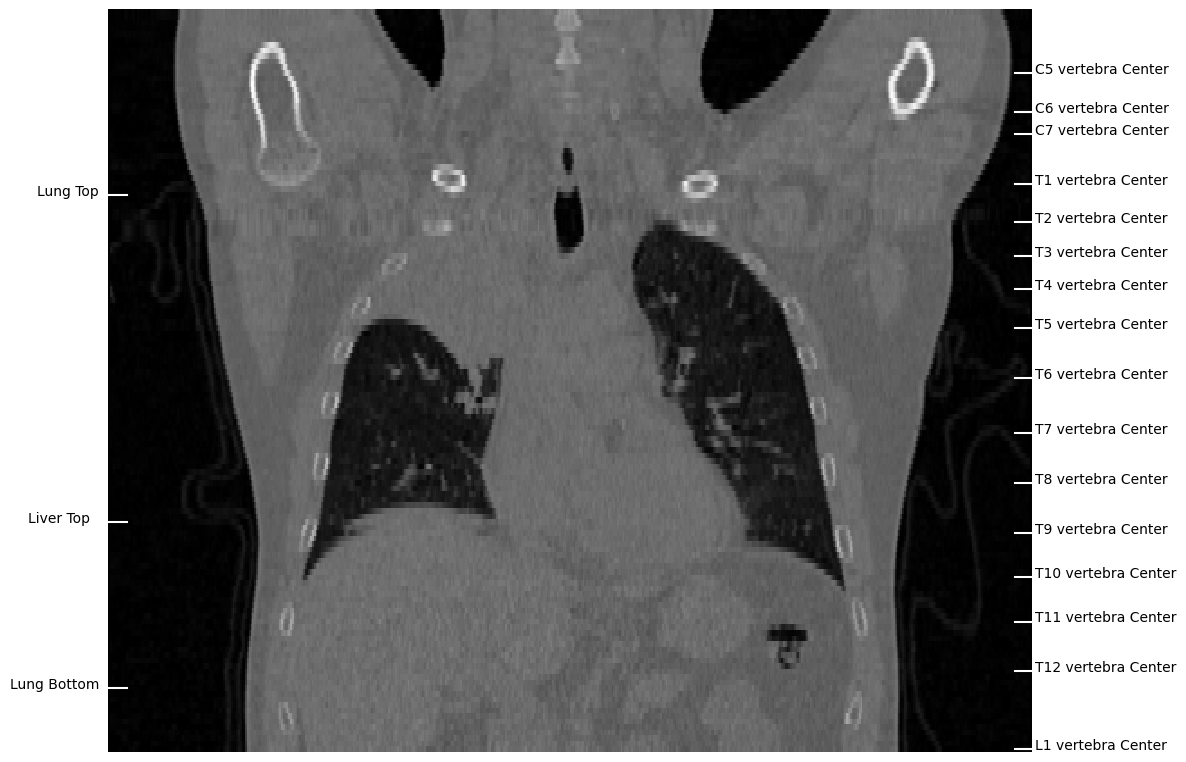

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(6,8)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  # plt.axhline(y=slice_index, color='w', linestyle='-')

  # plt.annotate(landmark_name,(dim[0],slice_index))
  if (('Bottom' in landmark_name) or ('Top' in landmark_name)):
    plt.plot([-10, 10], 
          [slice_index, slice_index],
          color='w', 
          linestyle='-')
    # plt.annotate(landmark_name,xy=(-60,slice_index), xycoords='data',annotation_clip=False)
    plt.annotate(landmark_name,xy=(len(landmark_name)*-5,slice_index), xycoords='data',annotation_clip=False)

  else: 
    plt.plot([dim[0]-10, dim[0]+10], 
          [slice_index, slice_index],
          color='w', 
          linestyle='-')
    plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

### **(paper figure #8)** NSCLC-Radiomics - Distributions of the distance between the superior slice of the expert lung delineations and the lung_top landmark, and between the inferior slice of the expert lung delineations and the lung_bottom landmark

First we have to get the bpr landmarks information of the lung 

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) 
print(table_id)

qual_df = client.query(landmarks_query_nsclc).to_dataframe()

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

# now just include where the region is lung and the modifier is top or bottom 
findingSite = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite'].values)]
findingSite_modifier = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite_topographicalModifier'].values)]

# add these to the df 
landmarks_series_df['landmark_name'] = findingSite  
landmarks_series_df['landmark_modifier'] = findingSite_modifier  

# now keep the ones with lung 
landmarks_series_df = landmarks_series_df[landmarks_series_df['landmark_name']=="Lung"]

bigquery-public-data.idc_v13.dicom_all


Now we have to calculate the actual position of the lung landmarks (top, bottom, or both) for each SOPInstanceUID. For this we need to query again. 

In [ ]:
sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) 

client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    DISTINCT(SOPInstanceUID),
    PatientID,
    StudyInstanceUID,
    SeriesInstanceUID, 
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url, 
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient
  FROM
    `bigquery-public-data.idc_v13.dicom_all` 
  WHERE
    SOPInstanceUID IN UNNEST(@sop_ids)
  ORDER BY 
    PatientID, 
    StudyInstanceUID;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ArrayQueryParameter("sop_ids", "STRING", sop_ids)
                                                      ])
result = client.query(query, job_config=job_config) 
sop_ipp_df = result.to_dataframe(create_bqstorage_client=True)

For each row, calculate the actual position and add it as a column to the table. 

In [ ]:
# sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) ## is this sourceReferencedSOPInstanceUID wrong?? 
sop_ids = list(sop_ipp_df['SOPInstanceUID'].values) 
num_series = len(sop_ids) 

pos_all = [] 

for n in range(0,num_series):
  
  sop_id = sop_ids[n] 
  # sop_df = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]
  sop_df = sop_ipp_df[sop_ipp_df['SOPInstanceUID']==sop_id]
  ImageOrientation = sop_df['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = sop_df['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

# landmarks_series_df['pos'] = pos_all 
sop_ipp_df['pos'] = pos_all

Let's add the landmark name and modifier to sop_ipp_df for the lung landmarks from the landmarks_series_df.

In [ ]:
landmark_names = [] 
landmark_modifiers = [] 

for n in range(0,num_series): 
  sop_id = sop_ids[n]
  # sop_df = sop_ipp_df[sop_ipp_df['SOPInstanceUID']==sop_id]
  landmark_name = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]['landmark_name'].values[0] 
  landmark_modifier = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]['landmark_modifier'].values[0]
  landmark_names.append(landmark_name)
  landmark_modifiers.append(landmark_modifier)
# Add to sop_ipp_df 
sop_ipp_df['landmark_name'] = landmark_names 
sop_ipp_df['landmark_modifier'] = landmark_modifiers 

In [ ]:
sop_ipp_df.head()

SOPInstanceUID  PatientID  \
0  1.3.6.1.4.1.32722.99.99.2631590101868572590236...  LUNG1-001   
1  1.3.6.1.4.1.32722.99.99.1132685649015073607577...  LUNG1-001   
2  1.3.6.1.4.1.32722.99.99.1410032064864351004350...  LUNG1-002   
3  1.3.6.1.4.1.32722.99.99.3363327544272700629355...  LUNG1-002   
4  1.3.6.1.4.1.32722.99.99.1747536477884928147436...  LUNG1-003   

                                    StudyInstanceUID  \
0  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
1  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
2  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
3  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
4  1.3.6.1.4.1.32722.99.99.2477262867958601216867...   

                                   SeriesInstanceUID  \
0  1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
1  1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
2  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
3  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
4  1.3.6.1.4.1.32722.99.99.2389222799296192439904...   

                                          viewer_url  \
0  https://viewer.imaging.datacommons.cancer.gov/...   
1  https://viewer.imaging.datacommons.cancer.gov/...   
2  https://viewer.imaging.datacommons.cancer.gov/...   
3  https://viewer.imaging.datacommons.cancer.gov/...   
4  https://viewer.imaging.datacommons.cancer.gov/...   

                 ImagePositionPatient  \
0  -249.51171875/-460.51171875/-612.5   
1  -249.51171875/-460.51171875/-354.5   
2        -250.1120/-250.1120/157.6000   
3       -250.1120/-250.1120/-103.4000   
4        -250.1120/-250.1120/-71.9000   

                     ImageOrientationPatient         pos landmark_name  \
0                                1/0/0/0/1/0 -612.500000          Lung   
1                                1/0/0/0/1/0 -354.500000          Lung   
2  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  157.600006          Lung   
3  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000 -103.400002          Lung   
4  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  -71.900002          Lung   

  landmark_modifier  
0            Bottom  
1               Top  
2               Top  
3            Bottom  
4               Top

Then we have to query for the ground truth segmentations for NSCLC-Radiomics

In [ ]:
client = bigquery.Client(project=project_name)

query = """

  # First get a list of the SOPInstanceUIDs of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection
  WITH seg_sops AS (
    SELECT 
      PatientID, 
      SeriesInstanceUID, 
      SOPInstanceUID,
      SeriesDescription,
      gcs_url
    FROM 
      `bigquery-public-data.idc_v13.dicom_all`
    WHERE
      Modality = "SEG" AND 
      collection_id = "nsclc_radiomics" AND 
      source_DOI = '10.7937/K9/TCIA.2015.PF0M9REI'
    ORDER BY 
      PatientID 
  )

  # Now join the above to get only the segmented_SeriesInstanceUIDs that have the regions we want
  # We will use these to get the AI-derived DICOM Segmentation objects 
  SELECT 
    DISTINCT(seg.segmented_SeriesInstanceUID), 
    seg.PatientID, 
    seg_sops.SOPInstanceUID,
    seg_sops.SeriesDescription,
    seg_sops.gcs_url

  FROM 
    `bigquery-public-data.idc_v13.segmentations` as seg 
  JOIN 
    seg_sops 
  ON 
    seg.SOPInstanceUID = seg_sops.SOPInstanceUID
  WHERE
    seg.SegmentedPropertyType.CodeMeaning = "Lung"
  ORDER BY 
    seg.PatientID; 

"""

seg_expert_df = client.query(query).to_dataframe()
series_ids = list(seg_expert_df['segmented_SeriesInstanceUID'].values)
print(len(series_ids))

411


We next need to get the image position patient and orientation information from the original CT files that correspond to these series. These will later be used to calculate the distances between the expert delineated lung and the landmarks. 

In [ ]:
client = bigquery.Client(project=project_name)

query = """
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    ARRAY_TO_STRING(ImagePositionPatient, "/") as ImagePositionPatient,
    ARRAY_TO_STRING(ImageOrientationPatient, "/") as ImageOrientationPatient,
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url
  FROM 
    `bigquery-public-data.idc_v13.dicom_all`
  WHERE
    SeriesInstanceUID IN UNNEST(@series_ids) AND 
    Modality = "CT" 
  ORDER BY 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID;
"""

job_config = bigquery.QueryJobConfig(    
    query_parameters=[
        bigquery.ArrayQueryParameter("series_ids", "STRING", series_ids)])
ct_df = client.query(query, job_config=job_config).to_dataframe()

Now we need to calculate the actual position for each row in ct_df

In [ ]:
num_rows = len(ct_df)
position = [] 

for n in range(0,num_rows):
  ImagePositionPatient = [np.float32(f) for f in ct_df['ImagePositionPatient'].values[n].split("/")]
  ImageOrientation = [np.float32(f) for f in ct_df['ImageOrientationPatient'].values[n].split("/")]
  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)
  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  position.append(pos)

# add to dataframe as column 
ct_df['position'] = position

Now we calculate the minimum and maximum of the lung segmentations and later compare them to the AI-derived body part regression lung landmarks. This process takes a while as we need to download and convert every SEG object. Therefore, to skip this process, you can load the results from github instead.

In [ ]:
# First get the list of SeriesInstanceUIDs that intersect between the ct_df and the sop_ipp_df 
# We may have series that were skipped by BPR because of pixel spacing or other issues, so we don't want to compute those in ct_df
# We also may have ones in sop_ipp_df that do not have ground truth 

series_id_list_ct = list(set(ct_df['SeriesInstanceUID'].values))
series_id_list_bpr = list(set(sop_ipp_df['SeriesInstanceUID'].values))
series_id_list_intersect = list(set(series_id_list_ct) & set(series_id_list_bpr))
print('series_id_list_ct: ' + str(len(series_id_list_ct)))
print('series_id_list_bpr: ' + str(len(series_id_list_bpr)))
print('series_id_list_intersect: ' + str(len(series_id_list_intersect)))

series_id_list_ct: 411
series_id_list_bpr: 413
series_id_list_intersect: 402


In [ ]:
if not (run_figure_8_expert_vs_ai_lung_segmentations):

  # Get the csv 
  lung_segmentation_locations_expert_csv = "/content/lung_segmentation_locations_expert.csv"
  !wget -O $lung_segmentation_locations_expert_csv https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/lung_segmentation_locations_expert.csv --no-check-certificate
  # Convert to dataframe 
  lung_df = pd.read_csv(lung_segmentation_locations_expert_csv)  


--2023-04-07 20:06:57--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/lung_segmentation_locations_expert.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304332 (297K) [text/plain]
Saving to: ‘/content/lung_segmentation_locations_expert.csv’

/content/lung_segme 100%[===================>] 297.20K  --.-KB/s    in 0.03s   

2023-04-07 20:06:58 (8.49 MB/s) - ‘/content/lung_segmentation_locations_expert.csv’ saved [304332/304332]



In [ ]:
# This will create the table 

if (run_figure_8_expert_vs_ai_lung_segmentations):

  dataset_table_id = 'dataset_nsclc' 
  # nnunet_comparison_table_id = 'usage_notebook_nnunet_comparison_table'
  lung_gt_table_id = 'usage_notebook_nsclc_groundtruth_lung'

  # Check if the dataset exists within the project 
  dataset_exists = dataset_exists_in_project(project_name, dataset_table_id)

  # If it does not exist, create the dataset 
  if not dataset_exists: 
    print ('creating dataset: ' + str(dataset_table_id))
    create_dataset(project_name, dataset_table_id)
  else:
    print ('dataset ' + str(dataset_table_id) + ' already exists.')

  # Set up the run parameters 

  # Dice score and HD score table 
  # If table doesn't exist, create the schema based on the above 

  from google.cloud.exceptions import NotFound
  client = bigquery.Client(project=project_name)

  lung_gt_table_id_fullname = '.'.join([project_name, dataset_table_id, lung_gt_table_id])
  print('lung_gt_table_id_fullname: ' + str(lung_gt_table_id_fullname))

  try:
    client.get_table(lung_gt_table_id_fullname) 
    lung_gt_table_exists = 1 
  except NotFound: 
    lung_gt_table_exists = 0 

  if (lung_gt_table_exists==0):

    schema = [
        bigquery.SchemaField("PatientID", "STRING", mode="REQUIRED"), 
        bigquery.SchemaField("SeriesInstanceUID", "STRING", mode="REQUIRED"), 
        bigquery.SchemaField("SOPInstanceUID", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("lung", "STRING", mode="REQUIRED"), # CHECK THIS.
        bigquery.SchemaField("ImagePositionPatient", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("ImageOrientationPatient", "STRING", mode="REQUIRED"),
        # bigquery.SchemaField("position", "FLOAT", mode="REQUIRED")
        bigquery.SchemaField("position", "STRING", mode="REQUIRED")
    ] 

    table = bigquery.Table(lung_gt_table_id_fullname, schema=schema)
    table = client.create_table(table)  # Make an API request.
    print(
        "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
    )

  else: 
    print ("Table " + str(lung_gt_table_id_fullname) + ' already exists.')

  # series_id_list = list(set(ct_df['SeriesInstanceUID'].values))
  # num_segs = len(series_id_list)
  num_segs = len(series_id_list_intersect)

  seg_dicom_directory = '/content/seg_files_dicom'
  seg_nifti_directory = '/content/seg_files_nifti'

  if not os.path.isdir(seg_dicom_directory): 
    os.mkdir(seg_dicom_directory)
  if not os.path.isdir(seg_nifti_directory):
    os.mkdir(seg_nifti_directory)

  lung_df = pd.DataFrame()
  lung_min_max_list = [] 
  lung_patient_id_list = [] 
  lung_series_id_list = [] 
  lung_sop_id_list = [] 
  lung_ImagePositionPatient_list = [] 
  lung_ImageOrientationPatient_list = [] 
  lung_position_list = [] 

  client = bigquery.Client(project=project_name)

  # --- For each seg, convert and get the extents --- # 

  for n in range(0,num_segs):

    # series_id = series_id_list[n]
    series_id = series_id_list_intersect[n] 
    # gcs_url = seg_df[seg_df['ReferencedSeriesInstanceUID']==series_id]['gcs_url'].values[0] 
    gcs_url = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]['gcs_url'].values[0]
    seg_dicom_file_path = os.path.join(seg_dicom_directory, 'seg.dcm')

    # patient_id = seg_df[seg_df['ReferencedSeriesInstanceUID']==series_id]["PatientID"].values[0] 
    patient_id = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]["PatientID"].values[0]
    print('patient_id: ' + str(patient_id))

    # Download DCM file 
    !gsutil cp $gcs_url $seg_dicom_file_path 

    # Convert from DICOM SEG to nifti 
    !segimage2itkimage --inputDICOM $seg_dicom_file_path --outputDirectory $seg_nifti_directory --outputType "nii"

    # Find the segments with lung in name and return min and max of each
    min_lung, max_lung = find_lung_extents(seg_nifti_directory) 
    print('min_lung: ' + str(min_lung))
    print('max_lung: ' + str(max_lung))

    # If lung is not found in the segments # should only happen for LUNG1-119 
    if (min_lung==-1 and max_lung==-1): 
      continue 
    # If lung is found in the segments 
    else: 
      # Get the df of the dicom files 
      # dicom_df = ct_df[ct_df['ReferencedSeriesInstanceUID']==series_id]
      dicom_df = ct_df[ct_df['SeriesInstanceUID']==series_id]
      # order from min to max position value 
      dicom_df = dicom_df.sort_values('position')

      # Get the corresponding SOPInstanceUIDs of the min and max slices 
      sop_ids = dicom_df['SOPInstanceUID'].values 
      min_sop_id = sop_ids[min_lung]
      max_sop_id = sop_ids[max_lung]
      min_ImagePositionPatient = dicom_df[dicom_df['SOPInstanceUID']==min_sop_id]['ImagePositionPatient'].values[0]
      max_ImagePositionPatient = dicom_df[dicom_df['SOPInstanceUID']==max_sop_id]['ImagePositionPatient'].values[0] 
      min_ImageOrientationPatient = dicom_df[dicom_df['SOPInstanceUID']==min_sop_id]['ImageOrientationPatient'].values[0]
      max_ImageOrientationPatient = dicom_df[dicom_df['SOPInstanceUID']==max_sop_id]['ImageOrientationPatient'].values[0]
      min_position = dicom_df[dicom_df['SOPInstanceUID']==min_sop_id]['position'].values[0] 
      max_position = dicom_df[dicom_df['SOPInstanceUID']==max_sop_id]['position'].values[0]

      # Save slice numbers to df with the corresponding sop 
      # For the min 
      lung_patient_id_list.append(patient_id)
      lung_series_id_list.append(series_id)
      lung_min_max_list.append('min')
      lung_sop_id_list.append(min_sop_id)
      lung_ImagePositionPatient_list.append(min_ImagePositionPatient)
      lung_ImageOrientationPatient_list.append(min_ImageOrientationPatient)
      lung_position_list.append(min_position)

      # For the max 
      lung_patient_id_list.append(patient_id)
      lung_series_id_list.append(series_id)
      lung_min_max_list.append('max')
      lung_sop_id_list.append(max_sop_id)
      lung_ImagePositionPatient_list.append(max_ImagePositionPatient)
      lung_ImageOrientationPatient_list.append(max_ImageOrientationPatient)
      lung_position_list.append(max_position)

      # add to table 

      row_to_insert = [] 
      row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                        ("SeriesInstanceUID", series_id), 
                                        ("SOPInstanceUID", min_sop_id), 
                                        ("lung", "min"), 
                                        ("ImagePositionPatient", min_ImagePositionPatient), 
                                        ("ImageOrientationPatient", min_ImageOrientationPatient), 
                                        ("position", str(min_position))
                                        ])
      row_to_insert.append(row_to_insert_dict)

      append_row_to_bq_table_with_query_lung( project_name, 
                                              dataset_table_id, 
                                              lung_gt_table_id, 
                                              series_id, 
                                              "min", 
                                              row_to_insert)

      row_to_insert = [] 
      row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                        ("SeriesInstanceUID", series_id), 
                                        ("SOPInstanceUID", max_sop_id), 
                                        ("lung", "max"), 
                                        ("ImagePositionPatient", max_ImagePositionPatient), 
                                        ("ImageOrientationPatient", max_ImageOrientationPatient), 
                                        ("position", str(max_position))
                                        ])
      row_to_insert.append(row_to_insert_dict)

      append_row_to_bq_table_with_query_lung( project_name, 
                                              dataset_table_id, 
                                              lung_gt_table_id, 
                                              series_id, 
                                              "max", 
                                              row_to_insert)
  

    # delete files in the seg_dicom_directory and seg_nifti_directory 
    !rm -r $seg_dicom_directory/* 
    !rm -r $seg_nifti_directory/*


  # --- Load the data needed for plotting --- # 

  client = bigquery.Client(project=project_name)
  lung_gt_table_id_fullname = ".".join([project_name, dataset_table_id, lung_gt_table_id])
  print('lung_gt_table_id_fullname: ' + str(lung_gt_table_id_fullname)) 
  query = f"""
    SELECT 
      * 
    FROM 
      {lung_gt_table_id_fullname};
  """
  lung_df = client.query(query).to_dataframe()


Now we are ready to plot the the lung extents from the expert vs the differences from the AI-derived lung landmarks. 

In [ ]:
# Get list of SeriesInstanceUIDs that overlap between the lung_gt_table and bpr_landmarks_df

series_id_list_gt = list(set(lung_df['SeriesInstanceUID'].values))
# series_id_list_bpr = list(set(bpr_landmarks_df['ReferencedSeriesInstanceUID'].values))
series_id_list_bpr = list(set(sop_ipp_df['SeriesInstanceUID'].values))

series_id_list_overlap = list(set(series_id_list_gt+series_id_list_bpr))
num_series = len(series_id_list_overlap)

# For each series get the difference between min and lung bottom (if it exists)
# and the difference between max and lung top (if it exists)
# write all fields and differences to new dataframe and then save as table 

PatientID_keep = [] 
SeriesInstanceUID_keep = [] 
SOPInstanceUID_keep = [] 
StudyInstanceUID_keep = [] 
ImagePositionPatient_keep = [] 
ImageOrientationPatient_keep = [] 
lung_keep = [] 
position_gt_keep = [] 
position_bpr_keep = [] 
position_diff_keep = [] 
viewer_urls = [] 

for n in range(0,num_series): 

  lung_min_gt = [] 
  lung_max_gt = [] 
  lung_min_bpr = [] 
  lung_max_bpr = [] 

  series_id = series_id_list_overlap[n]
  gt = lung_df[lung_df['SeriesInstanceUID']==series_id]
  # bpr = bpr_landmarks_df[bpr_landmarks_df['ReferencedSeriesInstanceUID']==series_id]
  bpr = sop_ipp_df[sop_ipp_df['SeriesInstanceUID']==series_id]

  lung_values_gt = list(gt['lung'].values)
  # lung_values_bpr = list(bpr['target_region_modifier'].values)
  lung_values_bpr = list(bpr['landmark_modifier'].values)

  #-- get difference between min and lung bottom if it exists --# 
  # gt 
  if('min' in list(lung_values_gt)): 
    lung_min_gt = gt[gt['lung']=='min']['position'].values[0]
  # bpr 
  if ('Bottom' in list(lung_values_bpr)): 
    # lung_min_bpr = bpr[bpr['target_region_modifier']=="Bottom"]['position'].values[0]
    lung_min_bpr = bpr[bpr['landmark_modifier']=="Bottom"]['pos'].values[0]

  #-- get difference between max and lung top if it exists --#
  # gt 
  if ('max' in list(lung_values_gt)): 
    lung_max_gt = gt[gt['lung']=='max']['position'].values[0]
  # bpr 
  if ('Top' in list(lung_values_bpr)): 
    # lung_max_bpr = bpr[bpr['target_region_modifier']=="Top"]['position'].values[0] 
    lung_max_bpr = bpr[bpr['landmark_modifier']=="Top"]['pos'].values[0]

  if (lung_min_gt and lung_min_bpr): 
    lung_min_diff = lung_min_gt-lung_min_bpr 
    # append
    PatientID = lung_df[lung_df['SeriesInstanceUID']==series_id]['PatientID'].values[0] 
    PatientID_keep.append(PatientID)
    SeriesInstanceUID_keep.append(series_id)
    # StudyInstanceUID = bpr_landmarks_df[bpr_landmarks_df['ReferencedSeriesInstanceUID']==series_id]['ReferencedStudyInstanceUID'].values[0] 
    # StudyInstanceUID_keep.append(StudyInstanceUID)
    SOPInstanceUID = gt[gt['lung']=='min']['SOPInstanceUID'].values[0]
    SOPInstanceUID_keep.append(SOPInstanceUID) # the ref 
    ImagePositionPatient = gt[gt['lung']=='min']['ImagePositionPatient'].values[0]
    ImagePositionPatient_keep.append(ImagePositionPatient)
    ImageOrientation = gt[gt['lung']=='min']['ImageOrientationPatient'].values[0]
    ImageOrientationPatient_keep.append(ImageOrientation)
    viewer_url = lung_df[lung_df['SeriesInstanceUID']==series_id]['viewer_url'].values[0] 
    lung_keep.append('min')
    position_gt_keep.append(lung_min_gt)
    position_bpr_keep.append(lung_min_bpr)
    position_diff_keep.append(np.abs(lung_min_diff)) # added absolute value
    viewer_urls.append(viewer_url)

  if (lung_max_gt and lung_max_bpr): 
    lung_max_diff = lung_max_gt - lung_max_bpr 
    # append
    PatientID = lung_df[lung_df['SeriesInstanceUID']==series_id]['PatientID'].values[0]
    PatientID_keep.append(PatientID)
    SeriesInstanceUID_keep.append(series_id)
    # StudyInstanceUID = bpr_landmarks_df[bpr_landmarks_df['ReferencedSeriesInstanceUID']==series_id]['ReferencedStudyInstanceUID'].values[0] 
    # StudyInstanceUID_keep.append(StudyInstanceUID)
    SOPInstanceUID = gt[gt['lung']=='max']['SOPInstanceUID'].values[0]
    SOPInstanceUID_keep.append(SOPInstanceUID) # the ref 
    ImagePositionPatient = gt[gt['lung']=='min']['ImagePositionPatient'].values[0]
    ImagePositionPatient_keep.append(ImagePositionPatient)
    ImageOrientation = gt[gt['lung']=='min']['ImageOrientationPatient'].values[0]
    viewer_url = lung_df[lung_df['SeriesInstanceUID']==series_id]['viewer_url'].values[0]
    ImageOrientationPatient_keep.append(ImageOrientation)
    lung_keep.append('max')
    position_gt_keep.append(lung_max_gt)
    position_bpr_keep.append(lung_max_bpr)
    position_diff_keep.append(np.abs(lung_max_diff)) # added absolute value
    viewer_urls.append(viewer_url)


lung_diff_df = pd.DataFrame( {'PatientID': PatientID_keep, 
                              # 'StudyInstanceUID': StudyInstanceUID_keep, 
                              'SeriesInstanceUID': SeriesInstanceUID_keep, 
                              'SOPInstanceUID': SOPInstanceUID_keep, 
                              'ImagePositionPatient': ImagePositionPatient_keep, 
                              'ImageOrientationPatient': ImageOrientationPatient_keep,
                              'lung': lung_keep,
                              'position_gt': position_gt_keep,
                              'position_bpr': position_bpr_keep,
                              'position_diff': position_diff_keep, 
                              'viewer_url': viewer_urls}) 

In [ ]:
df_plot = lung_diff_df.copy(deep=True)

In [ ]:
output_notebook()

# Get a color for each region 
# colormap, colors = color_list_generator(df_plot, 'regions')
colormap, colors = color_list_generator(df_plot, 'lung')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
regions = colormap_list_keys 

colors = list(colormap.values())

hover = HoverTool(tooltips=[
    ("(Height)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.lung.unique()

cats2 = [] 
for c in range(0,len(cats)): 
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2

colors2 = [] 
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          x_range=regions,
          title="Height of lung in mm")

l1 = p1.circle(y='position_diff', x=jitter('lung', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')

legend = Legend(items=[LegendItem(label=dict(field="lung"), renderers=[l1])])
p1.add_layout(legend, 'below')    

### Include the box plots ### 
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['lung2'] = [f + '_boxplot' for f in df_plot['lung'].values]

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['lung2'] = df_plot2['lung2'].astype(category_region)

groups = df_plot2.groupby('lung2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q2.position_diff,
    top=q3.position_diff,
    fill_color=colors2,
    legend=cats2
))

lower_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q1.position_diff,
    top=q2.position_diff,
    fill_color=colors2
))


# stems (Don't need colors of treatment)
p1.segment(cats2, upper.position_diff, cats2, q3.position_diff, line_color="black", alpha=0.5)
p1.segment(cats2, lower.position_diff, cats2, q1.position_diff, line_color="black", alpha=0.5)

# Add the upper and lower quartiles
l=p1.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
p1.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5)

# whiskers (almost-0 height rects simpler than segments)
p1.rect(cats2, lower.position_diff, 0.2, 0.000001, line_color="black", alpha=0.5) # was 0.01
p1.rect(cats2, upper.position_diff, 0.2, 0.000001, line_color="black", alpha=0.5)

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])]) 

# Setup plot titles and such.
p1.title.text = "Absolute difference in lung"
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = "white"
p1.grid.grid_line_width = 2
p1.xaxis.major_label_text_font_size="0pt"
p1.xaxis.major_label_orientation = np.pi/4
# p2.xaxis.axis_label="Regions"
p1.xaxis.axis_label = "Lung region"
# p2.yaxis.axis_label="Height of lung in mm"
p1.yaxis.axis_label = "Absolute difference in lung in mm"
p1.legend.location = (100,10)

p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

url="@viewer_url"
taptool = p1.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p1)


### **(paper figure #9)** NLST - Calculation of the distributions of the lung extent between the lung_bottom and lung_top landmarks 

Since we do not have expert segmentations of the lung for NLST like we do for NSCLC-Radiomics, one way that we can validate the landmark annotation is to calculate the distance between the lung_top and lung_bottom landmarks. We can then plot a distribution of these landmarks and see if there are any outliers, which could indicate an issue with either the landmark prediction or the anatomy of the patient.

We start by querying and creating a dataframe of the landmarks. 

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) 
print(table_id)

qual_df = client.query(landmarks_query_nlst).to_dataframe()

# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

# now just include where the region is lung and the modifier is top or bottom 
findingSite = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite'].values)]
findingSite_modifier = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite_topographicalModifier'].values)]
# add 
landmarks_series_df['landmark_name'] = findingSite  
landmarks_series_df['landmark_modifier'] = findingSite_modifier  
# now keep the ones with lung 
landmarks_series_df = landmarks_series_df[landmarks_series_df['landmark_name']=="Lung"]


bigquery-public-data.idc_v13.dicom_all


Now we have to calculate the actual position of the lung landmarks (top, bottom, or both) for each SOPInstanceUID. For this we need to query again. 

In [ ]:
sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) 

client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    DISTINCT(SOPInstanceUID),
    PatientID,
    StudyInstanceUID,
    SeriesInstanceUID, 
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url, 
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient
  FROM
    `bigquery-public-data.idc_v13.dicom_all` 
  WHERE
    SOPInstanceUID IN UNNEST(@sop_ids)
  ORDER BY 
    PatientID, 
    StudyInstanceUID;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ArrayQueryParameter("sop_ids", "STRING", sop_ids)
                                                      ])
result = client.query(query, job_config=job_config) 
sop_ipp_df = result.to_dataframe(create_bqstorage_client=True)

For each row, calculate the actual position and add it as a column to the table. 

In [ ]:
# sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) ## is this sourceReferencedSOPInstanceUID wrong?? 
sop_ids = list(sop_ipp_df['SOPInstanceUID'].values) 
num_series = len(sop_ids) 

pos_all = [] 

for n in range(0,num_series):
  
  sop_id = sop_ids[n] 
  # sop_df = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]
  sop_df = sop_ipp_df[sop_ipp_df['SOPInstanceUID']==sop_id]
  ImageOrientation = sop_df['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = sop_df['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

# landmarks_series_df['pos'] = pos_all 
sop_ipp_df['pos'] = pos_all

Now get the difference between each pair for each SeriesInstanceUID referenced. 

In [ ]:
series_ids = list(dict.fromkeys(sop_ipp_df['SeriesInstanceUID'].values))
num_series = len(series_ids) 
series_id_list = [] 
lung_values = [] 
viewer_urls = [] 

for n in range(0,num_series): 
  series_id = series_ids[n] 
  # series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==series_id]
  series_df = sop_ipp_df[sop_ipp_df['SeriesInstanceUID']==series_id]
  if (len(series_df)==2): 
    # lung_bottom = series_df[series_df['landmark_modifier']=="Bottom"]['pos'].values
    # lung_top = series_df[series_df['landmark_modifier']=="Top"]['pos'].values
    # print('lung_bottom: ' + str(lung_bottom) + ' lung_top: ' + str(lung_top))
    # order the values from min to max 
    lung_top_and_bottom = series_df['pos'].values 
    lung_bottom = np.min(lung_top_and_bottom) 
    lung_top = np.max(lung_top_and_bottom)
    series_id_list.append(series_id)
    lung_values.append(abs(lung_top-lung_bottom))
    viewer_urls.append(series_df['viewer_url'].values[0])

Create a dataframe

In [ ]:
df_plot = pd.DataFrame() 
df_plot['SeriesInstanceUID'] = series_id_list 
df_plot['regions'] = 'lung'
df_plot['height'] = np.asarray(lung_values)
df_plot['viewer_url'] = viewer_urls
# df_plot['viewer_url'] = landmarks_series_df[landmarks_series_df['crpes_ref'].isin(series_id_list)]['viewer_url'].values[::2]

Now plot a boxplot of the difference values including the OHIF url

In [ ]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
regions = colormap_list_keys 

colors = list(colormap.values())

hover = HoverTool(tooltips=[
    ("(Height)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()

cats2 = [] 
for c in range(0,len(cats)): 
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2

colors2 = [] 
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          x_range=regions,
          title="Height of lung in mm")

l1 = p1.circle(y='height', x=jitter('regions', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')

legend = Legend(items=[LegendItem(label=dict(field="regions"), renderers=[l1])])
p1.add_layout(legend, 'below')    

### Include the box plots ### 
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['regions2'] = [f + '_boxplot' for f in df_plot['regions'].values]

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['regions2'] = df_plot2['regions2'].astype(category_region)

# groups = df_plot.groupby('regions')
groups = df_plot2.groupby('regions2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q2.height,
    top=q3.height,
    fill_color=colors2,
    legend=cats2
))

lower_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q1.height,
    top=q2.height,
    fill_color=colors2
))


# stems (Don't need colors of treatment)
p1.segment(cats2, upper.height, cats2, q3.height, line_color="black", alpha=0.5)
p1.segment(cats2, lower.height, cats2, q1.height, line_color="black", alpha=0.5)

# Add the upper and lower quartiles
l=p1.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
p1.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5)

# whiskers (almost-0 height rects simpler than segments)
p1.rect(cats2, lower.height, 0.2, 0.000001, line_color="black", alpha=0.5) # was 0.01
p1.rect(cats2, upper.height, 0.2, 0.000001, line_color="black", alpha=0.5)

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="regions2"), renderers=[l])])

# Setup plot titles and such.
# p2.title.text = "Height of lung"
p1.title.text = "Lung height in mm"
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = "white"
p1.grid.grid_line_width = 2
p1.xaxis.major_label_text_font_size="0pt"
p1.xaxis.major_label_orientation = np.pi/4
p1.xaxis.axis_label = "Lung region"
p1.yaxis.axis_label = "Lung height in mm"
p1.legend.location = (100,10)

p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

url="@viewer_url"
taptool = p1.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p1)


check this value: 1
('#1b9e77',)
colormap: {'lung': '#1b9e77'}
colormap_list_keys: ['lung']
regions: ['lung']
colors: ['#1b9e77']
cats: ['lung']
regions: ['lung']
cats2: ['lung', 'lung_boxplot']
regions: ['lung', 'lung_boxplot']


### Query for lung top and lung bottom landmarks to see if any patients are missing them 

Let's query again to get the landmarks and regions df

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) 
print(table_id)

qual_df = client.query(landmarks_query_nlst).to_dataframe()

# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

bigquery-public-data.idc_v13.dicom_all


Now we want to get a list of OHIF urls that are missing the lung top or lung bottom landmark. 

In [ ]:
# Get a list of SeriesInstanceUIDs that don't have the lung bottom landmark 
landmark_all_series = list(set(landmarks_series_df['crpes_ref'].values))
print(len(landmark_all_series))
lung_top = [] 
lung_bottom = [] 

for n in range(0,len(landmark_all_series)): 

  single_series = landmark_all_series[n] 
  landmarks_single_series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==single_series] 
  findingSite = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite'].values]
  topModifier = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite_topographicalModifier'].values]
  # combine and add as column to single df 
  findingSite_and_mod = [f + ' ' + g for f,g in zip(findingSite, topModifier)]
  landmarks_single_series_df['findingSite_and_modifier'] = findingSite_and_mod 

  # Now return the series if it does not have Lung Top 
  check_lung_top = 0
  check_lung_bottom = 0 
  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Lung Top"])==0): 
    check_lung_top = 1 
    lung_top.append(single_series)
  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Lung Bottom"])==0): 
    check_lung_bottom = 1 
    lung_bottom.append(single_series)

lung_top_list = ['Lung Top' for f in lung_top]
lung_bottom_list = ['Lung Bottom' for f in lung_bottom]
lung_top_bottom_list = ['Lung Top' for f in lung_top] + ['Lung Bottom' for f in lung_bottom]

1039


Now get some sample OHIF links of those missing the top of the lung

In [ ]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) # later will change to use idc_v13. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@lung_top);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("lung_top", "STRING", lung_top)
                                                       ])
series_no_lung_top_df = client.query(query, job_config=job_config).to_dataframe()
print(len(series_no_lung_top_df))
series_no_lung_top_df['Lung landmark missing'] = lung_top_list 

bigquery-public-data.idc_v13.dicom_all
338


In [ ]:
series_no_lung_top_df.head()

viewer_url Lung landmark missing
0  https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
1  https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
2  https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
3  https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
4  https://viewer.imaging.datacommons.cancer.gov/...              Lung Top

### Query to see which patients contain the Kidney landmark

Now we will demonstrate how to query for series that contain a specific landmark like the Kidney.

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) 
print(table_id)

qual_df = client.query(landmarks_query_nlst).to_dataframe()

# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

bigquery-public-data.idc_v13.dicom_all


In [ ]:
# Get a list of SeriesInstanceUIDs that have the kidney 

landmark_all_series = list(set(landmarks_series_df['crpes_ref'].values))
print(len(landmark_all_series))
series_ids_keep = [] 
for n in range(0,len(landmark_all_series)): 

  single_series = landmark_all_series[n] 
  landmarks_single_series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==single_series] 
  findingSite = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite'].values]
  topModifier = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite_topographicalModifier'].values]
  # combine and add as column to single df 
  findingSite_and_mod = [f + ' ' + g for f,g in zip(findingSite, topModifier)]
  landmarks_single_series_df['findingSite_and_modifier'] = findingSite_and_mod 

  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Kidney Bottom"])==1): 
    series_ids_keep.append(single_series)


1039


In [ ]:
# Now get the OHIF urls of these series and view a few 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) # later will change to use idc_v13. 
print(table_id)

query = f"""
    SELECT 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
      SeriesInstanceUID
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@series_ids_keep);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("series_ids_keep", "STRING", series_ids_keep)
                                                       ])
series_with_kidney_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_v13.dicom_all


In [ ]:
series_with_kidney_df.head()

viewer_url  \
0  https://viewer.imaging.datacommons.cancer.gov/...   
1  https://viewer.imaging.datacommons.cancer.gov/...   
2  https://viewer.imaging.datacommons.cancer.gov/...   
3  https://viewer.imaging.datacommons.cancer.gov/...   
4  https://viewer.imaging.datacommons.cancer.gov/...   

                                   SeriesInstanceUID  
0  1.3.6.1.4.1.14519.5.2.1.7009.9004.257898790316...  
1  1.2.840.113654.2.55.19462141431396735333744469...  
2  1.3.6.1.4.1.14519.5.2.1.7009.9004.179356951104...  
3  1.3.6.1.4.1.14519.5.2.1.7009.9004.516724475814...  
4  1.2.840.113654.2.55.33388452429032704191006280...

### Download and read

Now we will use three packages to demonstrate how to read the landmarks SR files, using `dcmqi` and `highdicom`. 

#### Download a landmarks DICOM SR for a single series

In [ ]:
# Pick a single SOPInstanceUID 
SOPInstanceUID_landmarks = sorted(landmarks_series_df['SOPInstanceUID'].values) 
SOPInstanceUID_landmark = SOPInstanceUID_landmarks[0] 
SOPInstanceUID_landmark 

'1.2.826.0.1.3680043.8.498.10022894451655312600572372424452483460'

In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID_landmark)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_v13.dicom_all


In [ ]:
sr_df

SeriesDescription                                            gcs_url
0  BPR landmark annotations  gs://public-datasets-idc/de68842d-7e98-4df1-95...

In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr_landmarks"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/de68842d-7e98-4df1-95d1-2ee12b0699a4.dcm...
/ [1/1 files][ 27.5 KiB/ 27.5 KiB] 100% Done                                    
Operation completed over 1 objects/27.5 KiB.                                     
/content/sr_landmarks/de68842d-7e98-4df1-95d1-2ee12b0699a4.dcm
/content/sr_landmarks/sr.dcm


'/content/sr_landmarks/sr.dcm'

#### Read using dcmqi

In [ ]:
output_directory_sr_landmarks_converted_dcmqi = "/content/sr_landmarks_dcmqi"
if not os.path.isdir(output_directory_sr_landmarks_converted_dcmqi):
  os.mkdir(output_directory_sr_landmarks_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_landmarks_converted_dcmqi, 'sr_landmarks.json')

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_features_json = json.load(f)
sr_features_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'FindingSite': {'CodeMeaning': 'Kidney',
    'CodeValue': '64033007',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 1',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.57091474783457906193827367258599241805',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'L1 vertebra',
    'CodeValue': '66794005',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 2',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.51379287266227251514615256458835988913',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'Lung',
    'CodeValue': '39607008',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 3',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.21507763213376279897899278694740927101',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'T12

#### Read using highdicom

In [ ]:
# Read the landmarks SR 

landmarks_sr_df = pd.DataFrame() 
slice_indices = [] 
landmark_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain landmarks 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_landmarks = len(containers_level2)
print('num_slices_with_landmarks: ' + str(num_slices_with_landmarks))

# Loop over num_slices_with_landmarks
for slice_index in range(0,num_slices_with_landmarks):

  print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
  dataset=containers_level2[slice_index],
  relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the landmark and modifier 
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_landmarks_in_slice = len(containers_level3)
  print('   num_landmarks_in_slice: ' + str(num_landmarks_in_slice))

  # Loop over the number of landmarks in the slice 
  for landmark_index in range(0,num_landmarks_in_slice): 

    # Now get the landmark name 
    landmark_name = hd.sr.utils.get_coded_value(containers_level3[landmark_index])['CodeMeaning'].value
    print('   landmark_name: ' + str(landmark_name))

    # Now get the modifier
    modifier =  hd.sr.utils.find_content_items(
        dataset=containers_level3[landmark_index],
        relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
        value_type=ValueTypeValues.CODE
    )
    modifier_name = hd.sr.utils.get_coded_value(modifier[0])['CodeMeaning'].value
    print('   modifier_name: ' + str(modifier_name))

    slice_indices.append(slice_index)
    landmark_names.append(landmark_name)
    modifier_names.append(modifier_name)
    ref_sop_ids.append(sop_instance_uid)

# Create df
landmarks_sr_df['landmark_name'] = landmark_names 
landmarks_sr_df['modifier_name'] = modifier_names 
landmarks_sr_df['ref_sop_id'] = ref_sop_ids

landmarks_sr_df



sr_file: /content/sr_landmarks/sr.dcm
num_slices_with_landmarks: 20
slice_index: 0
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.305629633035562593745800399744408635913
   num_landmarks_in_slice: 2
   landmark_name: Kidney
   modifier_name: Bottom
   landmark_name: L2 vertebra
   modifier_name: Center
slice_index: 1
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.43054485334186588574623352561885187921
   num_landmarks_in_slice: 1
   landmark_name: L1 vertebra
   modifier_name: Center
slice_index: 2
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.263159010186857259023681147179880990863
   num_landmarks_in_slice: 1
   landmark_name: Lung
   modifier_name: Bottom
slice_index: 3
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.82802603186227822638651463200656463022
   num_landmarks_in_slice: 1
   landmark_name: T12 vertebra
   modifier_name: Center
slice_index: 4
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.8901906612198818796071007089102165819
 

landmark_name modifier_name  \
0         Kidney        Bottom   
1    L2 vertebra        Center   
2    L1 vertebra        Center   
3           Lung        Bottom   
4   T12 vertebra        Center   
5   T11 vertebra        Center   
6   T10 vertebra        Center   
7    T9 vertebra        Center   
8          Liver           Top   
9    T8 vertebra        Center   
10   T7 vertebra        Center   
11   T6 vertebra        Center   
12   T5 vertebra        Center   
13   T4 vertebra        Center   
14   T3 vertebra        Center   
15   T2 vertebra        Center   
16          Lung           Top   
17   T1 vertebra        Center   
18   C7 vertebra        Center   
19   C6 vertebra        Center   
20   C5 vertebra        Center   

                                           ref_sop_id  
0   1.3.6.1.4.1.32722.99.99.3056296330355625937458...  
1   1.3.6.1.4.1.32722.99.99.3056296330355625937458...  
2   1.3.6.1.4.1.32722.99.99.4305448533418658857462...  
3   1.3.6.1.4.1.32722.99.99.2631590101868572590236...  
4   1.3.6.1.4.1.32722.99.99.8280260318622782263865...  
5   1.3.6.1.4.1.32722.99.99.8901906612198818796071...  
6   1.3.6.1.4.1.32722.99.99.1651333239617429298390...  
7   1.3.6.1.4.1.32722.99.99.9243908860590178711883...  
8   1.3.6.1.4.1.32722.99.99.1378828584856047266870...  
9   1.3.6.1.4.1.32722.99.99.2451475860807041443665...  
10  1.3.6.1.4.1.32722.99.99.1868178790879465204302...  
11  1.3.6.1.4.1.32722.99.99.2606911222960897193555...  
12  1.3.6.1.4.1.32722.99.99.2685644298334541924431...  
13  1.3.6.1.4.1.32722.99.99.1348203431001892457304...  
14  1.3.6.1.4.1.32722.99.99.1526214918071743791952...  
15  1.3.6.1.4.1.32722.99.99.1457754966556520104945...  
16  1.3.6.1.4.1.32722.99.99.1132685649015073607577...  
17  1.3.6.1.4.1.32722.99.99.2004209890493027147183...  
18  1.3.6.1.4.1.32722.99.99.8272255297509386841485...  
19  1.3.6.1.4.1.32722.99.99.9026083532693705200338...  
20  1.3.6.1.4.1.32722.99.99.2018948692637691479971...

## Regions analysis

Now we focus on the regions SRs. 

### Query and extract values from regions SR


In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) 
print(table_id)

qual_df = client.query(landmarks_query_nlst).to_dataframe()

# We need to form a data frame 
# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# We already have the dataframe for the landmarks_regions_df 
regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

bigquery-public-data.idc_v13.dicom_all


We will pick a single series to analyze 

In [ ]:
series_id = sorted(regions_series_df['crpes_ref'].values)[0] 
print(series_id)

1.2.840.113654.2.55.10057224705584082952969157580585052644


Form a dataframe of just this series

In [ ]:
regions_series_df_keep = regions_series_df[regions_series_df["crpes_ref"]==series_id]


### For a single series, qualitatively plot the extent of each region 

We first need to get the CT files, download them and convert to nifti. 

In [ ]:
# For the single subject, get a coronal slices and plot the regions (like before) 

# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

### Query to get gcs_urls ### 

# series_id = series_ids_keep[n]
client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url,
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
    ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
  FROM
    `bigquery-public-data.idc_v13.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                      ])
result = client.query(query, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)

### Download the gcs_urls ###

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path_temp = "/content/raw_temp"
if not os.path.isdir(download_path_temp):
  os.mkdir(download_path_temp)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

### Convert to nii ### 

ct_nifti_directory_temp = "/content/ct_nii_temp" 
if not os.path.isdir(ct_nifti_directory_temp): 
  os.mkdir(ct_nifti_directory_temp)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
print(cmd)
ret = os.system(cmd)
print(ret)

# Rename file 
!rm -rf "/content/ct_qualitative"

nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
if not os.path.isdir("/content/ct_qualitative"):
  os.mkdir("/content/ct_qualitative")
os.rename(nii_file_orig, nii_file)

### Delete from folders ### 
!rm -rf "/content/raw_temp"
!rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_sop = len(series_df)
SOPInstanceUIDs = list(series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_sop): 
  
  sop_id = SOPInstanceUIDs[n] 
  series_df_temp = series_df[series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

series_df['pos'] = pos_all


Copying gs://public-datasets-idc/ee7dddeb-2b35-480b-b224-c99810af7998.dcm...
Copying gs://public-datasets-idc/1dcbc901-9f54-47a2-a699-bceb6365f61b.dcm...
Copying gs://public-datasets-idc/60d243de-0302-48ef-a68b-f7d5cbabd102.dcm...
Copying gs://public-datasets-idc/fa6c3712-dcc9-4d13-910c-83343fb7358f.dcm...
Copying gs://public-datasets-idc/219560fa-db7a-4643-9831-e76f94032d88.dcm...
Copying gs://public-datasets-idc/782b72ff-9bb5-4042-9301-d1f23ee669e6.dcm...
Copying gs://public-datasets-idc/c3296969-7a7c-4485-8569-bb22f51c22c5.dcm...
Copying gs://public-datasets-idc/9c76761e-0068-4482-9f8e-76dfb16ccf72.dcm...
Copying gs://public-datasets-idc/c2680b3e-f7e5-4820-89fe-296b0a00ae6d.dcm...
Copying gs://public-datasets-idc/5947ec5c-cee7-49e0-8d80-13f25f5f931c.dcm...
Copying gs://public-datasets-idc/75428b0d-857d-4e96-a695-99ec12055792.dcm...
Copying gs://public-datasets-idc/30ac338f-8b5d-44ef-ba96-73e93cb0f83a.dcm...
Copying gs://public-datasets-idc/4ac7a48d-02b1-43c4-a7a1-217004a008b4.dcm...

To the regions_series_df_keep, expand the columns that have the region, and add as new column. 

In [ ]:
num_rows = len(regions_series_df_keep)
region_list = [f['CodeMeaning'] for f in regions_series_df_keep['findingSite'].values]
regions_series_df_keep['region'] = region_list 

unique_regions: ['Abdomen', 'Chest', 'Neck']
num_unique_regions: 3


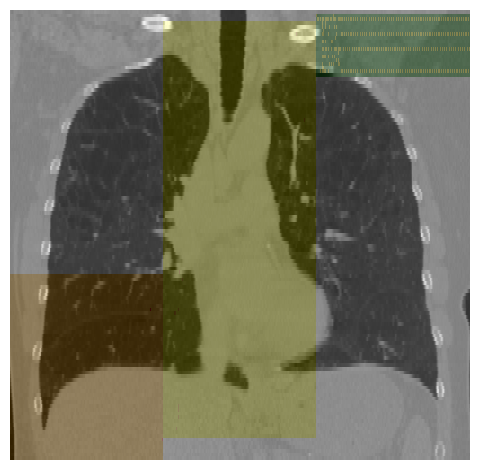

In [ ]:
ct_df_plot = series_df 
regions_df_plot = regions_series_df_keep 

# max number of regions is 6 
colors = ['y', 'r', 'g', 'b', 'c', 'm']
template_region_list = ["Legs", "Pelvis", "Abdomen", "Chest", "Neck", "Head"]

from matplotlib import colors
cmap = colors.ListedColormap(['white','red', 'orange', 'yellow', 'green', 'blue', 'purple'])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')

# For each unique region, annotate the axial extent
unique_regions = list(dict.fromkeys(region_list))
num_unique_regions = len(unique_regions)
print('unique_regions: ' + str(unique_regions))
print('num_unique_regions: ' + str(num_unique_regions))

bpr_slice = np.zeros((img.shape[0],img.shape[2]))
num_slices = img.shape[2]

for n in range(0,num_unique_regions):
  # get the region name 
  region_name = unique_regions[n]
  match_index = template_region_list.index(region_name)
  # get the list of measurement groups for the region 
  measurement_groups = regions_df_plot[regions_df_plot["region"]==unique_regions[n]]["measurementGroup_number"].values
  # get the min value 
  min_index = np.min(measurement_groups)
  # get the max value 
  max_index = np.max(measurement_groups)
  # get the ratios
  min_ratio = np.uint32(np.floor( (n)*(1/num_unique_regions) * dim[0]))
  max_ratio = np.uint32(np.floor( (n+1)*(1/num_unique_regions) * dim[0]))
  # form the slice
  bpr_slice[min_ratio:max_ratio,min_index:max_index] = match_index # so each region will have the same color 


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
bpr_slice_rotated = ndimage.rotate(bpr_slice,90)
ax.imshow(bpr_slice_rotated, cmap=cmap, aspect="auto", alpha=0.2, norm=norm, interpolation='none')
ax.set_aspect(cor_aspect)

plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 


In [ ]:
dim[2]-np.floor((max_index-min_index)/2)

167.0

In [ ]:
# # Get corresponding index of this landmark in the total list so we know what color to assign 
# landmark_name = landmarks_df_plot['landmark_names'].values[n] 
# ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
# color_index.append(ind)
# slice_index = landmarks_df_plot['slice_index'].values[n]
# slice_index = dim[2]-slice_index

# # plt.annotate(landmark_name,(dim[0],slice_index)) 
# plt.plot([dim[0]-10, dim[0]+10], 
#       [slice_index, slice_index],
#       color='w', 
#       linestyle='-')
# plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)

### Query for patients that have the chest as a region 

In [ ]:
# For each series, check if the chest is present in each 

all_series_ids = list(set(regions_series_df['crpes_ref'].values))
num_series_ids = len(all_series_ids) 

# form a df with the region 
region_list = [f['CodeMeaning'] for f in regions_series_df['findingSite'].values]
regions_series_df['region'] = region_list 

series_ids_no_chest = [] 

for n in range(0,num_series_ids): 
  # check if the chest is present 
  series_id = all_series_ids[n]
  region_names = regions_series_df[regions_series_df['crpes_ref']==series_id]['region'].values 
  if ("Chest" not in region_names):
    series_ids_no_chest.append(series_id)
print('series_ids_no_chest: ' + str(series_ids_no_chest)) # maybe can provide ohif links to these. 

series_ids_no_chest: []


Now let's compare the percentages that the chest covers over all series

In [ ]:
chest_percentages = [] 

for n in range(0,num_series_ids): 
  series_id = all_series_ids[n] 
  series_df = regions_series_df[regions_series_df['crpes_ref']==series_id]
  # get number of sop instance uids 
  num_sop = len(set(series_df['sourceReferencedSOPInstanceUID'].values))
  # get number where chest is present 
  num_chest = len(series_df[series_df['region'] == 'Chest'])
  chest_percentages.append(num_chest/num_sop)


Let's create a dataframe, link OHIF, and create a boxplot. For this we need the studyInstanceUID for each seriesInstanceUID. So we query. 

In [ ]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) # later will change to use idc_v13. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      # DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
      SeriesInstanceUID, 
      StudyInstanceUID
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@all_series_ids);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("all_series_ids", "STRING", all_series_ids)
                                                       ])
series_with_viewer_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_v13.dicom_all


In [ ]:
chest_df = pd.DataFrame() 
chest_df['regions'] = ['Chest'] * len(all_series_ids)
chest_df['SeriesInstanceUID'] = all_series_ids
chest_df['StudyInstanceUID'] = series_with_viewer_df['StudyInstanceUID'].values
chest_df['ratios'] = chest_percentages
chest_df['viewer_url'] = series_with_viewer_df['viewer_url'].values

df_plot = chest_df.copy(deep=True)

Now plot a boxplot showing the distribution of percentages 

In [ ]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
regions = colormap_list_keys 

colors = list(colormap.values())

hover = HoverTool(tooltips=[
    ("(Ratio)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()

cats2 = [] 
for c in range(0,len(cats)): 
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2

colors2 = [] 
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           title="Ratios of slices assigned to each region")

p.circle(y='ratios', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['regions2'] = [f + '_boxplot' for f in df_plot['regions'].values]

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['regions2'] = df_plot2['regions2'].astype(category_region)

groups = df_plot2.groupby('regions2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q2.ratios,
    top=q3.ratios,
    fill_color=colors2,
    legend=cats2
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q1.ratios,
    top=q2.ratios,
    fill_color=colors2
))
 
  
# stems (Don't need colors of treatment)
p.segment(cats2, upper.ratios, cats2, q3.ratios, line_color="black")
p.segment(cats2, lower.ratios, cats2, q1.ratios, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats2, lower.ratios, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats2, upper.ratios, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
  
# Setup plot titles and such.
p.title.text = "Ratio of slices for the chest"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Ratio"
p.legend.location = (100,10)

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)


#### 


You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.



### (paper figure #10) - NLST - Plot the distributions of ratios of slices assigned to each region

Let's calculate the percentages for each of the regions, and not only the chest 

In [ ]:
# Get the list of regions 
list_of_regions = list(set(regions_series_df['region'].values)) 
print('list_of_regions: ' + str(list_of_regions))

all_series_ids = list(set(regions_series_df['crpes_ref'].values))
num_series_ids = len(all_series_ids) 
print('num_series_ids: ' + str(num_series_ids))

### For each region ### 

region_percentages = [] 
region_series_ids = [] 
region_list = [] 

for m in range(0,len(list_of_regions)): 
  print(list_of_regions[m])
  ### For each series ### 
  for n in range(0,num_series_ids): 
    series_id = all_series_ids[n] 
    series_df = regions_series_df[regions_series_df['crpes_ref']==series_id]
    # get number where region is present 
    num_region = len(series_df[series_df['region'] == list_of_regions[m]])
    if (num_region>0):
      # get number of sop instance uids 
      num_sop = len(set(series_df['sourceReferencedSOPInstanceUID'].values))
      # Append
      region_series_ids.append(series_id)
      region_list.append(list_of_regions[m])
      region_percentages.append(num_region/num_sop)


list_of_regions: ['Head', 'Neck', 'Chest', 'Abdomen']
num_series_ids: 1039
Head
Neck
Chest
Abdomen


Let's start to form the dataframe for plotting

In [ ]:
df_plot = pd.DataFrame() 
df_plot['SeriesInstanceUID'] = region_series_ids 
df_plot['regions'] = region_list
df_plot['ratios'] = region_percentages 
df_plot 

SeriesInstanceUID  regions    ratios
0     1.2.840.113654.2.55.17922076604756733648279336...     Head  0.005952
1     1.2.840.113654.2.55.23221280541644487244147834...     Neck  0.218750
2     1.2.840.113654.2.55.25541800303697068660471237...     Neck  0.150327
3     1.2.840.113654.2.55.85329497298127431588006646...     Neck  0.146154
4     1.2.840.113654.2.55.21993346375295563704048013...     Neck  0.170068
...                                                 ...      ...       ...
3113  1.2.840.113654.2.55.80494687353065292799981397...  Abdomen  0.496933
3114  1.3.6.1.4.1.14519.5.2.1.7009.9004.247714574186...  Abdomen  0.494444
3115  1.3.6.1.4.1.14519.5.2.1.7009.9004.268056951592...  Abdomen  0.447205
3116  1.2.840.113654.2.55.11200505040770522192148926...  Abdomen  0.480000
3117  1.2.840.113654.2.55.14565458360164222986314008...  Abdomen  0.450000

[3118 rows x 3 columns]

Now let's query to get the ohif viewer links

In [ ]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all']) # later will change to use idc_v13. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      # DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
      SeriesInstanceUID, 
      StudyInstanceUID
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@all_series_ids);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("all_series_ids", "STRING", region_series_ids)
                                                       ])
df_ohif = client.query(query, job_config=job_config).to_dataframe()
df_ohif

bigquery-public-data.idc_current.dicom_all


viewer_url  \
0     https://viewer.imaging.datacommons.cancer.gov/...   
1     https://viewer.imaging.datacommons.cancer.gov/...   
2     https://viewer.imaging.datacommons.cancer.gov/...   
3     https://viewer.imaging.datacommons.cancer.gov/...   
4     https://viewer.imaging.datacommons.cancer.gov/...   
...                                                 ...   
1034  https://viewer.imaging.datacommons.cancer.gov/...   
1035  https://viewer.imaging.datacommons.cancer.gov/...   
1036  https://viewer.imaging.datacommons.cancer.gov/...   
1037  https://viewer.imaging.datacommons.cancer.gov/...   
1038  https://viewer.imaging.datacommons.cancer.gov/...   

                                      SeriesInstanceUID  \
0     1.3.6.1.4.1.14519.5.2.1.7009.9004.521159655064...   
1     1.2.840.113654.2.55.91128382240129837578953064...   
2     1.3.6.1.4.1.14519.5.2.1.7009.9004.145215505102...   
3     1.2.840.113654.2.55.17142342411879787281007051...   
4     1.2.840.113654.2.55.92439638084182625264054418...   
...                                                 ...   
1034  1.2.840.113654.2.55.25815236292721348182004483...   
1035  1.2.840.113654.2.55.11090290541952056021282007...   
1036  1.2.840.113654.2.55.13770085485581105817801470...   
1037  1.2.840.113654.2.55.33042012043362399213685129...   
1038  1.2.840.113654.2.55.24399045140600640333142580...   

                                       StudyInstanceUID  
0     1.3.6.1.4.1.14519.5.2.1.7009.9004.812754711637...  
1     1.2.840.113654.2.55.24646214503245500265392787...  
2     1.3.6.1.4.1.14519.5.2.1.7009.9004.143989807906...  
3     1.2.840.113654.2.55.27981087415460775607814808...  
4     1.2.840.113654.2.55.17030467485975653248399880...  
...                                                 ...  
1034  1.2.840.113654.2.55.26141669956613748257703185...  
1035  1.2.840.113654.2.55.21474429816804812247790802...  
1036  1.2.840.113654.2.55.27833382787807182584592525...  
1037  1.2.840.113654.2.55.16782374995397444318825508...  
1038  1.2.840.113654.2.55.27164227401096026992898909...  

[1039 rows x 3 columns]

Let's add the ohif viewer links to the dataframe 

In [ ]:

viewer_urls = [] 
for n in range(0,len(region_series_ids)):
  series_id = region_series_ids[n] 
  viewer_url = df_ohif[df_ohif['SeriesInstanceUID']==series_id]['viewer_url'].values[0] 
  viewer_urls.append(viewer_url)
df_plot['viewer_url'] = viewer_urls 


Let's plot the region percentages for NSLT 

In [ ]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
regions = colormap_list_keys 

colors = list(colormap.values())

hover = HoverTool(tooltips=[
    ("(Ratio)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()

cats2 = [] 
for c in range(0,len(cats)): 
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2

colors2 = [] 
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           title="Ratios of slices assigned to each region")

l = p.circle(y='ratios', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

legend = Legend(items=[LegendItem(label=dict(field="regions"), renderers=[l])])
p.add_layout(legend, 'below')    

### Include the box plots ### 
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['regions2'] = [f + '_boxplot' for f in df_plot['regions'].values]

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['regions2'] = df_plot2['regions2'].astype(category_region)

groups = df_plot2.groupby('regions2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q2.ratios,
    top=q3.ratios,
    fill_color=colors2,
    legend=cats2
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats2, 
    bottom=q1.ratios,
    top=q2.ratios,
    fill_color=colors2
))
 
  
# stems (Don't need colors of treatment)
p.segment(cats2, upper.ratios, cats2, q3.ratios, line_color="black")
p.segment(cats2, lower.ratios, cats2, q1.ratios, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats2, lower.ratios, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats2, upper.ratios, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
  
# Setup plot titles and such.
p.title.text = "Ratio of slices for each body part examined region"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Ratio"
p.legend.location = (100,10)
 
# show(p)

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'Head': '#1b9e77', 'Neck': '#d95f02', 'Chest': '#7570b3', 'Abdomen': '#e7298a'}
colormap_list_keys: ['Head', 'Neck', 'Chest', 'Abdomen']
regions: ['Head', 'Neck', 'Chest', 'Abdomen']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
cats: ['Head' 'Neck' 'Chest' 'Abdomen']
regions: ['Head', 'Neck', 'Chest', 'Abdomen']
cats2: ['Head', 'Head_boxplot', 'Neck', 'Neck_boxplot', 'Chest', 'Chest_boxplot', 'Abdomen', 'Abdomen_boxplot']
regions: ['Head', 'Head_boxplot', 'Neck', 'Neck_boxplot', 'Chest', 'Chest_boxplot', 'Abdomen', 'Abdomen_boxplot']


### Download and read

Now we will demonstrate how to download and read the SRs using `dcmqi` and `highdicom`. 

#### Download the regions DICOM SR for a single series 

In [ ]:
# landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]
regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

In [ ]:
# Pick a single SOPInstanceUID 
SOPInstanceUID_regions = regions_series_df['SOPInstanceUID'].values
SOPInstanceUID_region = SOPInstanceUID_regions[0] 
SOPInstanceUID_region 

'1.2.826.0.1.3680043.8.498.25960635473040653595015548112009004312'

In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID_region)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

SeriesDescription                                            gcs_url
0  BPR region annotations  gs://public-datasets-idc/ab50a4ce-1c66-4922-b0...

In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr_regions"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/b513185b-5b73-4ba4-b9e5-5556f674f2a3.dcm...
/ [1/1 files][134.8 KiB/134.8 KiB] 100% Done                                    
Operation completed over 1 objects/134.8 KiB.                                    
/content/sr_regions/b513185b-5b73-4ba4-b9e5-5556f674f2a3.dcm
/content/sr_regions/sr.dcm


'/content/sr_regions/sr.dcm'

#### Read using dcmqi

In [ ]:
output_directory_sr_regions_converted_dcmqi = "/content/sr_regions_dcmqi"
if not os.path.isdir(output_directory_sr_regions_converted_dcmqi):
  os.mkdir(output_directory_sr_regions_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_regions_converted_dcmqi, 'sr_regions.json')

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_regions_json = json.load(f)
sr_regions_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'FindingSite': {'CodeMeaning': 'Abdomen',
    'CodeValue': '113345001',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group 1',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.11884937171630796376602415032260386067',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'Abdomen',
    'CodeValue': '113345001',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group 2',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.51599504407767415983988674677261062239',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'Abdomen',
    'CodeValue': '113345001',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group 3',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.65274553289898767765738071649827580165',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'Abdomen',
    'CodeValue': '11

#### Read using highdicom

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

regions_sr_df = pd.DataFrame() 
slice_indices = [] 
region_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain regions 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_regions = len(containers_level2)
# print('num_slices_with_regions: ' + str(num_slices_with_regions))

# Loop over num_slices_with_regions
for slice_index in range(0,num_slices_with_regions):

  # print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
    dataset=containers_level2[slice_index],
    relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  # print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the region
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_regions_in_slice = len(containers_level3)
  # print('   num_regions_in_slice: ' + str(num_regions_in_slice))

  # Loop over the number of regions in the slice 
  for region_index in range(0,num_regions_in_slice): 

    # Now get the region name 
    region_name = hd.sr.utils.get_coded_value(containers_level3[region_index])['CodeMeaning'].value
    # print('   region_name: ' + str(region_name))

    slice_indices.append(slice_index)
    region_names.append(region_name)
    ref_sop_ids.append(sop_instance_uid)



# Create df
regions_sr_df['slice_index'] = slice_indices
regions_sr_df['region_name'] = region_names 
regions_sr_df['ref_sop_id'] = ref_sop_ids

regions_sr_df

sr_file: /content/sr_regions/sr.dcm


slice_index region_name  \
0              0     Abdomen   
1              1     Abdomen   
2              2     Abdomen   
3              3     Abdomen   
4              4     Abdomen   
..           ...         ...   
168          116       Chest   
169          116        Neck   
170          117        Neck   
171          118        Neck   
172          119        Neck   

                                            ref_sop_id  
0    1.2.840.113654.2.55.27676148827279216948356045...  
1    1.2.840.113654.2.55.32529763045243460483850212...  
2    1.2.840.113654.2.55.13424283959491496591382910...  
3    1.2.840.113654.2.55.28924543504581946122895215...  
4    1.2.840.113654.2.55.25279975618387749701949158...  
..                                                 ...  
168  1.2.840.113654.2.55.14280991515774492123294086...  
169  1.2.840.113654.2.55.14280991515774492123294086...  
170  1.2.840.113654.2.55.29329502146200218971474384...  
171  1.2.840.113654.2.55.21097501383403269977471449...  
172  1.2.840.113654.2.55.64453011115433206807862295...  

[173 rows x 3 columns]